In [ ]:
# import sys
# !{sys.executable} -m pip install imbalanced-learn --user
# !{sys.executable} -m pip install hyperopt --user

In [1]:
import numpy
from time import time
from sklearn.model_selection import GridSearchCV
from hyperopt import tpe, fmin, hp, STATUS_OK, Trials
from sklearn.metrics import accuracy_score, log_loss, roc_auc_score
from sklearn.model_selection import train_test_split
from copy import deepcopy

from newsgac import config
from newsgac.genres import genre_codes
from newsgac.learners import learners, LearnerSVC, LearnerNB, LearnerXGB, LearnerGB, LearnerMLP, LearnerRF, LearnerLGBM
from newsgac.pipelines.get_sk_pipeline import get_sk_pipeline
from newsgac.pipelines.utils import report
from sklearn.naive_bayes import MultinomialNB


from newsgac import database
from newsgac.data_sources import DataSource
from newsgac.pipelines import Pipeline

# from imblearn.under_sampling import RandomUnderSampler
# from imblearn.over_sampling import RandomOverSampler, SMOTE, ADASYN
# from imblearn.combine import SMOTEENN, SMOTETomek
import numpy as np
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /home/newsgac/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [2]:
[d.display_title for d in DataSource.objects.all()]

[u'N2BGS Training',
 u'N2BGS Testing',
 u'Linked NRC (2930)',
 u'BOW + 5 features (N2BGS train)',
 u'BOW + 5 features (N2BGS test)',
 u'nrc-1950-1994-a.txt',
 u'nrc-1950-1994-b.txt',
 u'nrc-1950-1994-c.txt',
 u'nrc-1950-1994-d.txt',
 u'nrc-1950-1994-e.txt',
 u'telegraaf-1950-1994-a.txt',
 u'telegraaf-1950-1994-b.txt',
 u'telegraaf-1950-1994-c.txt',
 u'telegraaf-1950-1994-d.txt',
 u'telegraaf-1950-1994-e.txt',
 u'volkskrant-1950-1995-a.txt',
 u'volkskrant-1950-1995-b.txt',
 u'volkskrant-1950-1995-c.txt',
 u'volkskrant-1950-1995-d.txt',
 u'volkskrant-1950-1995-e.txt',
 u'nrc-1965.txt',
 u'nrc-1985.txt',
 u'BOW + 9 features (N2BGS train)',
 u'BOW + 9 features (N2BGS test)',
 u'Linked NRC (2930/9 features)',
 u'BOW Train unique (9 features)',
 u'BOW Test unique (9 features)',
 u'Linked NRC (unique/9 features)',
 u'BOW Train unique (N3BGS/9 features)',
 u'N3BGS FROG Test',
 u'N3BGS FROG Train',
 u'BOW Test unique (N3BGS/9 features)']

In [3]:
[d.display_title for d in Pipeline.objects.all()]

[u'dummy frog',
 u'dummy bow',
 u'RF FROG',
 u'SVC FROG',
 u'XGB FROG',
 u'NB FROG',
 u'MLP FROG',
 u'RF BOW',
 u'SVC BOW',
 u'XGB BOW',
 u'NB BOW',
 u'MLP BOW',
 u'SVC LIN BOW',
 u'Erik MLP BOW (with stop-words)',
 u'Erik MLP BOW (5 features) ',
 u'Erik MLP BOW (9 features) ',
 u'Erik SVC BOW (9 features)',
 u'Erik RF BOW (9 features)',
 u'Erik XGB BOW (9 features)',
 u'Erik NB BOW (9 features)',
 u'Erik MLP unique 9 features',
 u'Erik NB unique (9 features)',
 u'Erik XGB unique (9 features)',
 u'Erik SVC unique (9 features)',
 u'Erik RF unique (9 features)',
 u'N3BGS MLP unique 9 features',
 u'N3BGS NB unique 9 features ',
 u'N3BGS SVC unique 9 features ',
 u'N3BGS RF unique 9 features',
 u'N3BGS XGB unique 9 features ',
 u'dummy n3bgs bow',
 u'dummy n3bgs frog']

In [4]:
p = Pipeline.objects.all()[30]
print 'DataSource: ' + p.data_source.display_title
print 'NLP Tool: ' + p.nlp_tool.name
print 'Classifier: ' + p.learner.name
print 'Task status: ' + str(p.task.status)

DataSource: BOW Train unique (N3BGS/9 features)
NLP Tool: TF-IDF
Classifier: Support Vector
Task status: Status.SUCCESS


In [5]:
len(p.data_source.articles)

857

In [6]:
test_data_source = DataSource.objects.all()[31]
print 'Testing data source: ' + test_data_source.display_title

Testing data source: BOW Test unique (N3BGS/9 features)


In [7]:
skp = p.get_sk_pipeline()
skp_opt = deepcopy(skp)
skp_opt.steps.pop()
skp_opt.steps

[('CleanOCR', <newsgac.nlp_tools.transformers.CleanOCR at 0x7efcf7682110>),
 ('StopWordRemoval',
  <newsgac.nlp_tools.transformers.StopWordRemoval at 0x7efcf7682150>),
 ('FeatureExtraction', FeatureUnion(n_jobs=None,
         transformer_list=[('TFIDF', Pipeline(memory=None,
       steps=[('RemoveQuotes', <newsgac.nlp_tools.transformers.RemoveQuotes object at 0x7efcf7682190>), ('TF-IDF', TfidfVectorizer(analyzer=u'word', binary=False, decode_error=u'strict',
          dtype=<type 'numpy.float64'>, encoding=u'utf-8', input=u'content',
          lowercase=True, max_df=1.0, max_featu...        token_pattern=u'(?u)\\b\\w\\w+\\b', tokenizer=None, use_idf=True,
          vocabulary=None))]))],
         transformer_weights=None))]

In [8]:
texts = numpy.array([article.raw_text for article in p.data_source.articles])
labels = numpy.array([article.label for article in p.data_source.articles])

X = skp_opt.fit_transform(texts)

In [9]:
# get the test dataset for optimization accuracy
texts_test = numpy.array([article.raw_text for article in test_data_source.articles])
labels_test = numpy.array([article.label for article in test_data_source.articles])

X_test = skp_opt.transform(texts_test)

In [10]:
X_train = X
y_train = labels
y_test = labels_test

In [11]:
y_test.shape

(95,)

In [12]:
def optimize(evals, trials, optimizer=tpe.suggest):
    space = {
        'alpha': hp.uniform('alpha', 0.0, 5.0),
    }
    best = fmin(score, space, algo=optimizer, max_evals=evals, trials=trials)
    pbar.close()
    return best

In [13]:
train_acc_list = []
train_loss_list = []
test_acc_list = []
test_loss_list = []

def score(params):
    
    model = MultinomialNB(alpha=params['alpha'])

    model.fit(X_train, y_train)   

    train_acc = accuracy_score(y_train, model.predict(X_train))
    train_loss = log_loss(y_train, model.predict_proba(X_train))
    test_acc = accuracy_score(y_test, model.predict(X_test))
    test_loss = log_loss(y_test, model.predict_proba(X_test))
    
    train_acc_list.append(train_acc)
    train_loss_list.append(train_loss)
    test_acc_list.append(test_acc)
    test_loss_list.append(test_loss)
    
    print('Parameters with this training accuracy {} and loss {} :'.format(train_acc, train_loss))
    print('Parameters with this testing accuracy {} and loss {} :'.format(test_acc, test_loss))
    print(params)
    pbar.update()
#     return {'loss': test_loss, 'status': STATUS_OK}
    return {'loss': -test_acc, 'status': STATUS_OK}

In [14]:
import time
from tqdm import tqdm
import numpy as np

trials = Trials()
cores = 48
start = time.time()
evaluations = 1000
pbar = tqdm(total=evaluations, desc="Hyperopt")
best_param = optimize(evals=evaluations,
                      optimizer=tpe.suggest,
                      trials=trials)
print("------------------------------------")
print("The best hyperparameters are: ", "\n")
print(best_param)
end = time.time()
print('Time elapsed to optimize {0} executions: {1}'.format(evaluations, end - start))
print('\n Best score:')
score(best_param)

Hyperopt:   0%|          | 5/1000 [00:00<00:22, 43.55it/s]

Parameters with this training accuracy 0.997666277713 and loss 0.0110269472659 :
Parameters with this testing accuracy 0.305263157895 and loss 3.21206015359 :
{'alpha': 0.003206298625275106}
Parameters with this training accuracy 0.935822637106 and loss 1.38223919878 :
Parameters with this testing accuracy 0.357894736842 and loss 2.25086877546 :
{'alpha': 0.8853683711354099}
Parameters with this training accuracy 0.890315052509 and loss 1.9892439686 :
Parameters with this testing accuracy 0.357894736842 and loss 2.46773901205 :
{'alpha': 2.1736038981273857}
Parameters with this training accuracy 0.866977829638 and loss 2.30253389477 :
Parameters with this testing accuracy 0.347368421053 and loss 2.58979637225 :
{'alpha': 4.2050118899104785}
Parameters with this training accuracy 0.926487747958 and loss 1.59889442458 :
Parameters with this testing accuracy 0.357894736842 and loss 2.32455127296 :
{'alpha': 1.184256846915654}
Parameters with this training accuracy 0.94049008168 and loss 1

Hyperopt:   2%|▏         | 16/1000 [00:00<00:21, 46.14it/s]

Parameters with this training accuracy 0.886814469078 and loss 2.0671989532 :
Parameters with this testing accuracy 0.357894736842 and loss 2.49772421103 :
{'alpha': 2.50798242657668}
Parameters with this training accuracy 0.886814469078 and loss 2.01909553956 :
Parameters with this testing accuracy 0.357894736842 and loss 2.47917910028 :
{'alpha': 2.2932865286999107}
Parameters with this training accuracy 0.87747957993 and loss 2.23465367862 :
Parameters with this testing accuracy 0.357894736842 and loss 2.56308345059 :
{'alpha': 3.5611545723370206}
Parameters with this training accuracy 0.886814469078 and loss 2.06898432942 :
Parameters with this testing accuracy 0.357894736842 and loss 2.49841493831 :
{'alpha': 2.5165281478401025}
Parameters with this training accuracy 0.886814469078 and loss 2.03786237592 :
Parameters with this testing accuracy 0.357894736842 and loss 2.4863987562 :
{'alpha': 2.3736297409952254}
Parameters with this training accuracy 0.889148191365 and loss 1.99662

Hyperopt:   3%|▎         | 26/1000 [00:00<00:21, 46.31it/s]

Parameters with this training accuracy 0.880980163361 and loss 2.16837443406 :
Parameters with this testing accuracy 0.357894736842 and loss 2.53709539555 :
{'alpha': 3.0734770891957517}
Parameters with this training accuracy 0.880980163361 and loss 2.1573592072 :
Parameters with this testing accuracy 0.357894736842 and loss 2.5327890637 :
{'alpha': 3.0027385446907857}
Parameters with this training accuracy 0.85764294049 and loss 2.35165765906 :
Parameters with this testing accuracy 0.336842105263 and loss 2.60915941115 :
{'alpha': 4.801880648620902}
Parameters with this training accuracy 0.997666277713 and loss 0.0144794285851 :
Parameters with this testing accuracy 0.326315789474 and loss 2.46166488061 :
{'alpha': 0.009829718275777388}
Parameters with this training accuracy 0.880980163361 and loss 2.15013789704 :
Parameters with this testing accuracy 0.357894736842 and loss 2.52996824459 :
{'alpha': 2.957742235482523}
Parameters with this training accuracy 0.869311551925 and loss 2.2

Hyperopt:   4%|▎         | 36/1000 [00:00<00:21, 45.76it/s]

Parameters with this training accuracy 0.883313885648 and loss 2.11528449189 :
Parameters with this testing accuracy 0.357894736842 and loss 2.51638170172 :
{'alpha': 2.75467607212719}
Parameters with this training accuracy 0.997666277713 and loss 0.0196721990261 :
Parameters with this testing accuracy 0.347368421053 and loss 2.15986762545 :
{'alpha': 0.018525054865989876}
Parameters with this training accuracy 0.859976662777 and loss 2.33191022431 :
Parameters with this testing accuracy 0.336842105263 and loss 2.60137397586 :
{'alpha': 4.545805963768472}
Parameters with this training accuracy 0.869311551925 and loss 2.29587091973 :
Parameters with this testing accuracy 0.347368421053 and loss 2.58717143646 :
{'alpha': 4.13361120131931}
Parameters with this training accuracy 0.966161026838 and loss 0.750197562509 :
Parameters with this testing accuracy 0.389473684211 and loss 2.05545433068 :
{'alpha': 0.39517688141284824}
Parameters with this training accuracy 0.962660443407 and loss 0

Hyperopt:   5%|▍         | 46/1000 [00:01<00:21, 45.15it/s]

Parameters with this training accuracy 0.978996499417 and loss 0.332168111161 :
Parameters with this testing accuracy 0.410526315789 and loss 1.93216904645 :
{'alpha': 0.19992548223348813}
Parameters with this training accuracy 0.929988331389 and loss 1.48766561197 :
Parameters with this testing accuracy 0.357894736842 and loss 2.28620962705 :
{'alpha': 1.0173020410089235}
Parameters with this training accuracy 0.943990665111 and loss 1.20876978548 :
Parameters with this testing accuracy 0.357894736842 and loss 2.19469667949 :
{'alpha': 0.7095523442020903}
Parameters with this training accuracy 0.918319719953 and loss 1.70715409437 :
Parameters with this testing accuracy 0.357894736842 and loss 2.36294174141 :
{'alpha': 1.3827075472775723}
Parameters with this training accuracy 0.978996499417 and loss 0.285232577044 :
Parameters with this testing accuracy 0.410526315789 and loss 1.9180174309 :
{'alpha': 0.17940971650851428}
Parameters with this training accuracy 0.89731621937 and loss 

Hyperopt:   6%|▌         | 56/1000 [00:01<00:21, 44.90it/s]

Parameters with this training accuracy 0.926487747958 and loss 1.57034572864 :
Parameters with this testing accuracy 0.357894736842 and loss 2.31460451596 :
{'alpha': 1.1382470361886394}
Parameters with this training accuracy 0.896149358226 and loss 1.93626452227 :
Parameters with this testing accuracy 0.357894736842 and loss 2.44758008515 :
{'alpha': 1.9827696248289208}
Parameters with this training accuracy 0.952158693116 and loss 1.0678224295 :
Parameters with this testing accuracy 0.368421052632 and loss 2.15067608283 :
{'alpha': 0.5945686596855096}
Parameters with this training accuracy 0.983663943991 and loss 0.144056845908 :
Parameters with this testing accuracy 0.389473684211 and loss 1.87795545482 :
{'alpha': 0.1131555753386697}
Parameters with this training accuracy 0.911318553092 and loss 1.78493497291 :
Parameters with this testing accuracy 0.357894736842 and loss 2.39117577489 :
{'alpha': 1.553843650006541}
Parameters with this training accuracy 0.880980163361 and loss 2.1

Hyperopt:   7%|▋         | 66/1000 [00:01<00:20, 45.00it/s]

Parameters with this training accuracy 0.890315052509 and loss 1.99433089068 :
Parameters with this testing accuracy 0.357894736842 and loss 2.46968452549 :
{'alpha': 2.1933334308296644}
Parameters with this training accuracy 0.9008168028 and loss 1.87444521237 :
Parameters with this testing accuracy 0.357894736842 and loss 2.4243156234 :
{'alpha': 1.789398038185192}
Parameters with this training accuracy 0.883313885648 and loss 2.09668061639 :
Parameters with this testing accuracy 0.357894736842 and loss 2.50915040134 :
{'alpha': 2.6549933358988054}
Parameters with this training accuracy 0.94049008168 and loss 1.28272310605 :
Parameters with this testing accuracy 0.357894736842 and loss 2.21835689421 :
{'alpha': 0.7791457360644265}
Parameters with this training accuracy 0.910151691949 and loss 1.79503701239 :
Parameters with this testing accuracy 0.357894736842 and loss 2.39488189919 :
{'alpha': 1.578174466528418}
Parameters with this training accuracy 0.880980163361 and loss 2.194036

Hyperopt:   8%|▊         | 76/1000 [00:01<00:20, 44.70it/s]

Parameters with this training accuracy 0.997666277713 and loss 0.0108740996573 :
Parameters with this testing accuracy 0.305263157895 and loss 3.27981094785 :
{'alpha': 0.00293715620781676}
Parameters with this training accuracy 0.922987164527 and loss 1.67887541828 :
Parameters with this testing accuracy 0.357894736842 and loss 2.35281113608 :
{'alpha': 1.3268411435657175}
Parameters with this training accuracy 0.966161026838 and loss 0.708742015307 :
Parameters with this testing accuracy 0.4 and loss 2.04328561554 :
{'alpha': 0.373447795006677}
Parameters with this training accuracy 0.935822637106 and loss 1.38949899046 :
Parameters with this testing accuracy 0.357894736842 and loss 2.25327213665 :
{'alpha': 0.8937613676070703}
Parameters with this training accuracy 0.966161026838 and loss 0.75641499433 :
Parameters with this testing accuracy 0.389473684211 and loss 2.05728230911 :
{'alpha': 0.398502906362956}
Parameters with this training accuracy 0.928821470245 and loss 1.514836225

Hyperopt:   9%|▊         | 86/1000 [00:01<00:20, 44.86it/s]

Parameters with this training accuracy 0.862310385064 and loss 2.32716078344 :
Parameters with this testing accuracy 0.347368421053 and loss 2.59950175464 :
{'alpha': 4.487633525768308}
Parameters with this training accuracy 0.982497082847 and loss 0.179822318113 :
Parameters with this testing accuracy 0.4 and loss 1.88701235697 :
{'alpha': 0.1311432703308824}
Parameters with this training accuracy 0.982497082847 and loss 0.157776598645 :
Parameters with this testing accuracy 0.4 and loss 1.88121733246 :
{'alpha': 0.12021450149042934}
Parameters with this training accuracy 0.899649941657 and loss 1.8937254792 :
Parameters with this testing accuracy 0.357894736842 and loss 2.43153986422 :
{'alpha': 1.8466858324875646}
Parameters with this training accuracy 0.890315052509 and loss 1.97030174926 :
Parameters with this testing accuracy 0.357894736842 and loss 2.46050937738 :
{'alpha': 2.1023951127658616}
Parameters with this training accuracy 0.911318553092 and loss 1.78338785743 :
Paramet

Hyperopt:  10%|▉         | 96/1000 [00:02<00:22, 40.05it/s]

Parameters with this training accuracy 0.973162193699 and loss 0.554458053708 :
Parameters with this testing accuracy 0.4 and loss 1.99811145031 :
{'alpha': 0.2983614737138062}
Parameters with this training accuracy 0.886814469078 and loss 2.03621776015 :
Parameters with this testing accuracy 0.357894736842 and loss 2.48576525282 :
{'alpha': 2.366421472293322}
Parameters with this training accuracy 0.928821470245 and loss 1.51299053941 :
Parameters with this testing accuracy 0.357894736842 and loss 2.29484244832 :
{'alpha': 1.0525398958437637}
Parameters with this training accuracy 0.933488914819 and loss 1.43715326931 :
Parameters with this testing accuracy 0.357894736842 and loss 2.26915823146 :
{'alpha': 0.9512948627462781}
Parameters with this training accuracy 0.903150525088 and loss 1.8469424498 :
Parameters with this testing accuracy 0.357894736842 and loss 2.41406199018 :
{'alpha': 1.7119639182011208}
Parameters with this training accuracy 0.962660443407 and loss 0.837474539024

Hyperopt:  10%|█         | 101/1000 [00:02<00:21, 41.01it/s]

Parameters with this training accuracy 0.978996499417 and loss 0.371732649156 :
Parameters with this testing accuracy 0.4 and loss 1.9440492338 :
{'alpha': 0.21710769475249841}
Parameters with this training accuracy 0.955659276546 and loss 1.01980374691 :
Parameters with this testing accuracy 0.368421052632 and loss 2.1359685595 :
{'alpha': 0.5597996984723677}
Parameters with this training accuracy 0.997666277713 and loss 0.0140579527159 :
Parameters with this testing accuracy 0.326315789474 and loss 2.50869701273 :
{'alpha': 0.009044913846818242}
Parameters with this training accuracy 0.870478413069 and loss 2.27454066732 :
Parameters with this testing accuracy 0.357894736842 and loss 2.57877170857 :
{'alpha': 3.9180044336353137}
Parameters with this training accuracy 0.894982497083 and loss 1.94084670426 :
Parameters with this testing accuracy 0.357894736842 and loss 2.44931589118 :
{'alpha': 1.9982865383425827}
Parameters with this training accuracy 0.883313885648 and loss 2.0904946

Hyperopt:  11%|█         | 111/1000 [00:02<00:22, 39.47it/s]

Parameters with this training accuracy 0.862310385064 and loss 2.32650053952 :
Parameters with this testing accuracy 0.347368421053 and loss 2.59924149766 :
{'alpha': 4.479645615213786}
Parameters with this training accuracy 0.85764294049 and loss 2.3566269445 :
Parameters with this testing accuracy 0.336842105263 and loss 2.61111872048 :
{'alpha': 4.870182022649865}
Parameters with this training accuracy 0.879813302217 and loss 2.21318448654 :
Parameters with this testing accuracy 0.347368421053 and loss 2.55465261579 :
{'alpha': 3.390371951321346}
Parameters with this training accuracy 0.966161026838 and loss 0.701844487483 :
Parameters with this testing accuracy 0.4 and loss 2.04126372525 :
{'alpha': 0.36990474646567595}
Parameters with this training accuracy 0.882147024504 and loss 2.13340806082 :
Parameters with this testing accuracy 0.357894736842 and loss 2.52344060574 :
{'alpha': 2.8574617595026317}
Parameters with this training accuracy 0.935822637106 and loss 1.39678885187 :


Hyperopt:  12%|█▏        | 116/1000 [00:02<00:23, 37.87it/s]

Parameters with this training accuracy 0.886814469078 and loss 2.01016968652 :
Parameters with this testing accuracy 0.357894736842 and loss 2.47575263308 :
{'alpha': 2.2564937724349727}
Parameters with this training accuracy 0.978996499417 and loss 0.321539071807 :
Parameters with this testing accuracy 0.410526315789 and loss 1.92896776592 :
{'alpha': 0.19529969250550316}
Parameters with this training accuracy 0.941656942824 and loss 1.23728649156 :
Parameters with this testing accuracy 0.357894736842 and loss 2.2037715858 :
{'alpha': 0.7355402837538421}
Parameters with this training accuracy 0.918319719953 and loss 1.70606850422 :
Parameters with this testing accuracy 0.357894736842 and loss 2.36255150397 :
{'alpha': 1.3805049888570537}
Parameters with this training accuracy 0.997666277713 and loss 0.0113377481257 :
Parameters with this testing accuracy 0.305263157895 and loss 3.08860059677 :
{'alpha': 0.0037762586090057115}
Parameters with this training accuracy 0.925320886814 and l

Hyperopt:  12%|█▎        | 125/1000 [00:02<00:23, 37.16it/s]

Parameters with this training accuracy 0.987164527421 and loss 0.109633504336 :
Parameters with this testing accuracy 0.368421052632 and loss 1.87211014797 :
{'alpha': 0.09420773799985115}
Parameters with this training accuracy 0.880980163361 and loss 2.17355302311 :
Parameters with this testing accuracy 0.357894736842 and loss 2.53912134 :
{'alpha': 3.1076453035013274}
Parameters with this training accuracy 0.949824970828 and loss 1.13721402056 :
Parameters with this testing accuracy 0.368421052632 and loss 2.17218162378 :
{'alpha': 0.6485698169081616}
Parameters with this training accuracy 0.866977829638 and loss 2.30318445979 :
Parameters with this testing accuracy 0.347368421053 and loss 2.59005269205 :
{'alpha': 4.212093032121158}
Parameters with this training accuracy 0.968494749125 and loss 0.661783873538 :
Parameters with this testing accuracy 0.4 and loss 2.02953143065 :
{'alpha': 0.3497058080753469}
Parameters with this training accuracy 0.898483080513 and loss 1.89916942746 

Hyperopt:  13%|█▎        | 134/1000 [00:03<00:23, 36.39it/s]

Parameters with this training accuracy 0.961493582264 and loss 0.904398877302 :
Parameters with this testing accuracy 0.378947368421 and loss 2.10113255198 :
{'alpha': 0.48367082509965514}
Parameters with this training accuracy 0.912485414236 and loss 1.75199670595 :
Parameters with this testing accuracy 0.357894736842 and loss 2.37915376355 :
{'alpha': 1.4780186899216097}
Parameters with this training accuracy 0.977829638273 and loss 0.42034391375 :
Parameters with this testing accuracy 0.4 and loss 1.95855360626 :
{'alpha': 0.23827607952254648}
Parameters with this training accuracy 0.952158693116 and loss 1.06304702872 :
Parameters with this testing accuracy 0.368421052632 and loss 2.14920728849 :
{'alpha': 0.5910204910079807}
Parameters with this training accuracy 0.906651108518 and loss 1.82276285946 :
Parameters with this testing accuracy 0.357894736842 and loss 2.40509879257 :
{'alpha': 1.647739368029832}
Parameters with this training accuracy 0.922987164527 and loss 1.654589031

Hyperopt:  14%|█▍        | 143/1000 [00:03<00:22, 38.10it/s]

Parameters with this training accuracy 0.859976662777 and loss 2.33909948458 :
Parameters with this testing accuracy 0.336842105263 and loss 2.60420818116 :
{'alpha': 4.636308734838796}
Parameters with this training accuracy 0.987164527421 and loss 0.121139310035 :
Parameters with this testing accuracy 0.389473684211 and loss 1.8735372283 :
{'alpha': 0.10077804914240529}
Parameters with this training accuracy 0.89731621937 and loss 1.9236636091 :
Parameters with this testing accuracy 0.357894736842 and loss 2.44281453504 :
{'alpha': 1.940989310698751}
Parameters with this training accuracy 0.928821470245 and loss 1.54074066187 :
Parameters with this testing accuracy 0.357894736842 and loss 2.30436720589 :
{'alpha': 1.092939854771915}
Parameters with this training accuracy 0.942823803967 and loss 1.23275731914 :
Parameters with this testing accuracy 0.357894736842 and loss 2.20232624994 :
{'alpha': 0.7313441944918686}
Parameters with this training accuracy 0.996499416569 and loss 0.0255

Hyperopt:  15%|█▌        | 153/1000 [00:03<00:20, 40.75it/s]

Parameters with this training accuracy 0.966161026838 and loss 0.811948082583 :
Parameters with this testing accuracy 0.389473684211 and loss 2.07365303769 :
{'alpha': 0.4290514628346734}
Parameters with this training accuracy 0.978996499417 and loss 0.340759345691 :
Parameters with this testing accuracy 0.410526315789 and loss 1.9347539274 :
{'alpha': 0.20365955513866646}
Parameters with this training accuracy 0.969661610268 and loss 0.633475286349 :
Parameters with this testing accuracy 0.4 and loss 2.02124741375 :
{'alpha': 0.33579731833128607}
Parameters with this training accuracy 0.978996499417 and loss 0.27406375657 :
Parameters with this testing accuracy 0.421052631579 and loss 1.9146499512 :
{'alpha': 0.17447934092552173}
Parameters with this training accuracy 0.98016336056 and loss 0.213120886004 :
Parameters with this testing accuracy 0.410526315789 and loss 1.89647965148 :
{'alpha': 0.1469372953504998}
Parameters with this training accuracy 0.997666277713 and loss 0.0147276

Hyperopt:  16%|█▋        | 163/1000 [00:03<00:19, 42.69it/s]

Parameters with this training accuracy 0.971995332555 and loss 0.572301927692 :
Parameters with this testing accuracy 0.4 and loss 2.00334114363 :
{'alpha': 0.3066535243773746}
Parameters with this training accuracy 0.981330221704 and loss 0.189858714007 :
Parameters with this testing accuracy 0.410526315789 and loss 1.8897996432 :
{'alpha': 0.1359815937666474}
Parameters with this training accuracy 0.94049008168 and loss 1.29029172234 :
Parameters with this testing accuracy 0.357894736842 and loss 2.22080184095 :
{'alpha': 0.7866874892374696}
Parameters with this training accuracy 0.962660443407 and loss 0.839396432589 :
Parameters with this testing accuracy 0.378947368421 and loss 2.08177867514 :
{'alpha': 0.44474766757125284}
Parameters with this training accuracy 0.945157526254 and loss 1.19658761553 :
Parameters with this testing accuracy 0.357894736842 and loss 2.19083803155 :
{'alpha': 0.6987553928709032}
Parameters with this training accuracy 0.925320886814 and loss 1.623653514

Hyperopt:  17%|█▋        | 168/1000 [00:03<00:19, 42.55it/s]

Parameters with this training accuracy 0.975495915986 and loss 0.461149471744 :
Parameters with this testing accuracy 0.4 and loss 1.97065137654 :
{'alpha': 0.2562212385608873}
Parameters with this training accuracy 0.921820303384 and loss 1.68810504355 :
Parameters with this testing accuracy 0.357894736842 and loss 2.35610962215 :
{'alpha': 1.3447357632753005}
Parameters with this training accuracy 0.929988331389 and loss 1.48824164798 :
Parameters with this testing accuracy 0.357894736842 and loss 2.28640536023 :
{'alpha': 1.018086980595033}
Parameters with this training accuracy 0.955659276546 and loss 0.992773279129 :
Parameters with this testing accuracy 0.368421052632 and loss 2.1277475573 :
{'alpha': 0.5410749591298731}
Parameters with this training accuracy 0.967327887981 and loss 0.675722954524 :
Parameters with this testing accuracy 0.4 and loss 2.03361196245 :
{'alpha': 0.35666273929053494}
Parameters with this training accuracy 0.978996499417 and loss 0.395976939236 :
Param

Hyperopt:  18%|█▊        | 178/1000 [00:04<00:19, 43.24it/s]

Parameters with this training accuracy 0.873978996499 and loss 2.26070050653 :
Parameters with this testing accuracy 0.357894736842 and loss 2.57332496286 :
{'alpha': 3.7878142647897954}
Parameters with this training accuracy 0.865810968495 and loss 2.30749929074 :
Parameters with this testing accuracy 0.347368421053 and loss 2.59175281879 :
{'alpha': 4.25956444277662}
Parameters with this training accuracy 0.963827304551 and loss 0.831057193842 :
Parameters with this testing accuracy 0.389473684211 and loss 2.079307304 :
{'alpha': 0.4399348464267026}
Parameters with this training accuracy 0.938156359393 and loss 1.35633479345 :
Parameters with this testing accuracy 0.357894736842 and loss 2.24232867263 :
{'alpha': 0.8561735763304674}
Parameters with this training accuracy 0.885647607935 and loss 2.07937335379 :
Parameters with this testing accuracy 0.357894736842 and loss 2.50243746062 :
{'alpha': 2.567145960046788}
Parameters with this training accuracy 0.911318553092 and loss 1.7820

Hyperopt:  19%|█▉        | 188/1000 [00:04<00:18, 43.69it/s]

Parameters with this training accuracy 0.978996499417 and loss 0.30946753609 :
Parameters with this testing accuracy 0.421052631579 and loss 1.92532853307 :
{'alpha': 0.19003466884042436}
Parameters with this training accuracy 0.883313885648 and loss 2.11168587586 :
Parameters with this testing accuracy 0.357894736842 and loss 2.51498172916 :
{'alpha': 2.734948691065395}
Parameters with this training accuracy 0.987164527421 and loss 0.125113610681 :
Parameters with this testing accuracy 0.389473684211 and loss 1.87417740895 :
{'alpha': 0.10298647706626723}
Parameters with this training accuracy 0.95682613769 and loss 0.969392554289 :
Parameters with this testing accuracy 0.378947368421 and loss 2.12066837437 :
{'alpha': 0.5253388422977535}
Parameters with this training accuracy 0.890315052509 and loss 1.98707005164 :
Parameters with this testing accuracy 0.357894736842 and loss 2.46690809851 :
{'alpha': 2.1652523763204443}
Parameters with this training accuracy 0.882147024504 and loss 

Hyperopt:  20%|█▉        | 198/1000 [00:04<00:18, 43.98it/s]

Parameters with this training accuracy 0.938156359393 and loss 1.32521971751 :
Parameters with this testing accuracy 0.357894736842 and loss 2.23214320003 :
{'alpha': 0.8225883990984793}
Parameters with this training accuracy 0.903150525088 and loss 1.85021401623 :
Parameters with this testing accuracy 0.357894736842 and loss 2.41527846877 :
{'alpha': 1.7209233663076997}
Parameters with this training accuracy 0.97666277713 and loss 0.441404283348 :
Parameters with this testing accuracy 0.4 and loss 1.96480571576 :
{'alpha': 0.24751086554565754}
Parameters with this training accuracy 0.997666277713 and loss 0.0190847928425 :
Parameters with this testing accuracy 0.336842105263 and loss 2.17995774208 :
{'alpha': 0.017616994498530686}
Parameters with this training accuracy 0.87747957993 and loss 2.23140034878 :
Parameters with this testing accuracy 0.357894736842 and loss 2.56180520943 :
{'alpha': 3.534393654411409}
Parameters with this training accuracy 0.933488914819 and loss 1.42254629

Hyperopt:  21%|██        | 208/1000 [00:04<00:17, 44.26it/s]

Parameters with this training accuracy 0.928821470245 and loss 1.53438711459 :
Parameters with this testing accuracy 0.357894736842 and loss 2.30218040585 :
{'alpha': 1.0835186468977547}
Parameters with this training accuracy 0.922987164527 and loss 1.65372584524 :
Parameters with this testing accuracy 0.357894736842 and loss 2.34386237997 :
{'alpha': 1.2796682009669984}
Parameters with this training accuracy 0.869311551925 and loss 2.29232759487 :
Parameters with this testing accuracy 0.347368421053 and loss 2.58577570798 :
{'alpha': 4.096455443931612}
Parameters with this training accuracy 0.886814469078 and loss 2.05379269698 :
Parameters with this testing accuracy 0.357894736842 and loss 2.49254291628 :
{'alpha': 2.445196512103633}
Parameters with this training accuracy 0.955659276546 and loss 1.03281378601 :
Parameters with this testing accuracy 0.368421052632 and loss 2.13994002974 :
{'alpha': 0.5690244900674688}
Parameters with this training accuracy 0.971995332555 and loss 0.57

Hyperopt:  21%|██▏       | 213/1000 [00:04<00:18, 43.54it/s]

Parameters with this training accuracy 0.894982497083 and loss 1.94762859027 :
Parameters with this testing accuracy 0.357894736842 and loss 2.45188774579 :
{'alpha': 2.0215786958629374}
Parameters with this training accuracy 0.947491248541 and loss 1.18888519115 :
Parameters with this testing accuracy 0.357894736842 and loss 2.18840382587 :
{'alpha': 0.6920198315019634}
Parameters with this training accuracy 0.962660443407 and loss 0.897645663306 :
Parameters with this testing accuracy 0.378947368421 and loss 2.0991138344 :
{'alpha': 0.47950530178125417}
Parameters with this training accuracy 0.978996499417 and loss 0.33379748473 :
Parameters with this testing accuracy 0.410526315789 and loss 1.93265947707 :
{'alpha': 0.2006339500559918}
Parameters with this training accuracy 0.966161026838 and loss 0.742166597258 :
Parameters with this testing accuracy 0.4 and loss 2.05309439776 :
{'alpha': 0.39090730443863525}
Parameters with this training accuracy 0.926487747958 and loss 1.57028134

Hyperopt:  22%|██▏       | 223/1000 [00:05<00:17, 43.68it/s]

Parameters with this training accuracy 0.912485414236 and loss 1.75488190573 :
Parameters with this testing accuracy 0.357894736842 and loss 2.38020299873 :
{'alpha': 1.4844544522192293}
Parameters with this training accuracy 0.863477246208 and loss 2.31891004899 :
Parameters with this testing accuracy 0.347368421053 and loss 2.59624965199 :
{'alpha': 4.389497572632077}
Parameters with this training accuracy 0.933488914819 and loss 1.43612334812 :
Parameters with this testing accuracy 0.357894736842 and loss 2.26881285515 :
{'alpha': 0.9500047440971127}
Parameters with this training accuracy 0.85764294049 and loss 2.3577691983 :
Parameters with this testing accuracy 0.336842105263 and loss 2.61156909749 :
{'alpha': 4.886115201518094}
Parameters with this training accuracy 0.952158693116 and loss 1.05773634813 :
Parameters with this testing accuracy 0.368421052632 and loss 2.14757548225 :
{'alpha': 0.5870986692307069}
Parameters with this training accuracy 0.970828471412 and loss 0.6105

Hyperopt:  23%|██▎       | 233/1000 [00:05<00:17, 43.46it/s]

Parameters with this training accuracy 0.978996499417 and loss 0.237655415274 :
Parameters with this testing accuracy 0.410526315789 and loss 1.90372603391 :
{'alpha': 0.15818644980578592}
Parameters with this training accuracy 0.929988331389 and loss 1.49419230407 :
Parameters with this testing accuracy 0.357894736842 and loss 2.28842905819 :
{'alpha': 1.0262401508345123}
Parameters with this training accuracy 0.947491248541 and loss 1.1688800615 :
Parameters with this testing accuracy 0.357894736842 and loss 2.18210122668 :
{'alpha': 0.6748462615898065}
Parameters with this training accuracy 0.966161026838 and loss 0.777806243794 :
Parameters with this testing accuracy 0.389473684211 and loss 2.06357848859 :
{'alpha': 0.4100873017696779}
Parameters with this training accuracy 0.94049008168 and loss 1.26335483764 :
Parameters with this testing accuracy 0.357894736842 and loss 2.21212038306 :
{'alpha': 0.7602147307773512}
Parameters with this training accuracy 0.905484247375 and loss 1

Hyperopt:  24%|██▍       | 243/1000 [00:05<00:17, 43.51it/s]

Parameters with this training accuracy 0.859976662777 and loss 2.34720973157 :
Parameters with this testing accuracy 0.336842105263 and loss 2.60740570473 :
{'alpha': 4.742109818649333}
Parameters with this training accuracy 0.984830805134 and loss 0.137862123127 :
Parameters with this testing accuracy 0.389473684211 and loss 1.87660889428 :
{'alpha': 0.10988955992984928}
Parameters with this training accuracy 0.997666277713 and loss 0.0159923268859 :
Parameters with this testing accuracy 0.326315789474 and loss 2.33365909301 :
{'alpha': 0.012537076091068106}
Parameters with this training accuracy 0.969661610268 and loss 0.632423897999 :
Parameters with this testing accuracy 0.4 and loss 2.02093977829 :
{'alpha': 0.33528620984424884}
Parameters with this training accuracy 0.952158693116 and loss 1.04550183958 :
Parameters with this testing accuracy 0.368421052632 and loss 2.14382264496 :
{'alpha': 0.5781587404558051}
Parameters with this training accuracy 0.870478413069 and loss 2.2751

Hyperopt:  25%|██▌       | 253/1000 [00:05<00:17, 43.61it/s]

Parameters with this training accuracy 0.928821470245 and loss 1.53781798823 :
Parameters with this testing accuracy 0.357894736842 and loss 2.30336081581 :
{'alpha': 1.088593132640492}
Parameters with this training accuracy 0.883313885648 and loss 2.10932040172 :
Parameters with this testing accuracy 0.357894736842 and loss 2.51406179375 :
{'alpha': 2.722099891735919}
Parameters with this training accuracy 0.97666277713 and loss 0.441349542037 :
Parameters with this testing accuracy 0.4 and loss 1.96478948839 :
{'alpha': 0.24748679245860886}
Parameters with this training accuracy 0.89731621937 and loss 1.92792500985 :
Parameters with this testing accuracy 0.357894736842 and loss 2.44442485376 :
{'alpha': 1.954974653271474}
Parameters with this training accuracy 0.949824970828 and loss 1.13837210748 :
Parameters with this testing accuracy 0.368421052632 and loss 2.17254320006 :
{'alpha': 0.6495118773670001}
Parameters with this training accuracy 0.929988331389 and loss 1.46505812794 :


Hyperopt:  26%|██▌       | 258/1000 [00:06<00:17, 43.46it/s]

Parameters with this training accuracy 0.943990665111 and loss 1.22757040948 :
Parameters with this testing accuracy 0.357894736842 and loss 2.20067289078 :
{'alpha': 0.7265709612213627}
Parameters with this training accuracy 0.967327887981 and loss 0.680419062251 :
Parameters with this testing accuracy 0.4 and loss 2.03498705731 :
{'alpha': 0.3590233568721194}
Parameters with this training accuracy 0.880980163361 and loss 2.16620396308 :
Parameters with this testing accuracy 0.357894736842 and loss 2.53624653722 :
{'alpha': 3.0593323500033742}
Parameters with this training accuracy 0.875145857643 and loss 2.24528251538 :
Parameters with this testing accuracy 0.357894736842 and loss 2.56726109137 :
{'alpha': 3.6509125492787753}
Parameters with this training accuracy 0.978996499417 and loss 0.372184855369 :
Parameters with this testing accuracy 0.4 and loss 1.94418464421 :
{'alpha': 0.21730406200123537}
Parameters with this training accuracy 0.981330221704 and loss 0.201605688842 :
Para

Hyperopt:  27%|██▋       | 268/1000 [00:06<00:16, 43.07it/s]

Parameters with this training accuracy 0.973162193699 and loss 0.5408989061 :
Parameters with this testing accuracy 0.4 and loss 1.99413412707 :
{'alpha': 0.2921168165851208}
Parameters with this training accuracy 0.955659276546 and loss 1.01222724627 :
Parameters with this testing accuracy 0.368421052632 and loss 2.13366016994 :
{'alpha': 0.5544919956295385}
Parameters with this training accuracy 0.98016336056 and loss 0.213988594543 :
Parameters with this testing accuracy 0.410526315789 and loss 1.89673318024 :
{'alpha': 0.1473399395508497}
Parameters with this training accuracy 0.93698949825 and loss 1.37377162093 :
Parameters with this testing accuracy 0.357894736842 and loss 2.24807111004 :
{'alpha': 0.8756973442211176}
Parameters with this training accuracy 0.95682613769 and loss 0.942927730689 :
Parameters with this testing accuracy 0.378947368421 and loss 2.11268916231 :
{'alpha': 0.5080160357840198}
Parameters with this training accuracy 0.950991831972 and loss 1.09868814267 :

Hyperopt:  28%|██▊       | 278/1000 [00:06<00:16, 42.71it/s]

Parameters with this training accuracy 0.974329054842 and loss 0.506619093233 :
Parameters with this testing accuracy 0.4 and loss 1.98406172292 :
{'alpha': 0.27652676236880813}
Parameters with this training accuracy 0.978996499417 and loss 0.327076106906 :
Parameters with this testing accuracy 0.410526315789 and loss 1.93063584066 :
{'alpha': 0.1977104043663073}
Parameters with this training accuracy 0.926487747958 and loss 1.59759862114 :
Parameters with this testing accuracy 0.357894736842 and loss 2.32409820141 :
{'alpha': 1.1821167283194456}
Parameters with this training accuracy 0.934655775963 and loss 1.40528381895 :
Parameters with this testing accuracy 0.357894736842 and loss 2.25851293178 :
{'alpha': 0.9123410494461659}
Parameters with this training accuracy 0.989498249708 and loss 0.068242463413 :
Parameters with this testing accuracy 0.347368421053 and loss 1.87851223143 :
{'alpha': 0.06737192072524031}
Parameters with this training accuracy 0.962660443407 and loss 0.844294

Hyperopt:  29%|██▉       | 288/1000 [00:06<00:16, 42.16it/s]

Parameters with this training accuracy 0.929988331389 and loss 1.48059812256 :
Parameters with this testing accuracy 0.357894736842 and loss 2.28381050841 :
{'alpha': 1.0077326511974385}
Parameters with this training accuracy 0.971995332555 and loss 0.573875300306 :
Parameters with this testing accuracy 0.4 and loss 2.0038020615 :
{'alpha': 0.30738888564738476}
Parameters with this training accuracy 0.988331388565 and loss 0.0847939275603 :
Parameters with this testing accuracy 0.357894736842 and loss 1.87260366803 :
{'alpha': 0.07886689184617951}
Parameters with this training accuracy 0.925320886814 and loss 1.64192856108 :
Parameters with this testing accuracy 0.357894736842 and loss 2.33968444176 :
{'alpha': 1.2583075343148007}
Parameters with this training accuracy 0.952158693116 and loss 1.0622817836 :
Parameters with this testing accuracy 0.368421052632 and loss 2.14897204723 :
{'alpha': 0.5904538173241961}
Parameters with this training accuracy 0.927654609102 and loss 1.54706329

Hyperopt:  30%|██▉       | 298/1000 [00:06<00:16, 42.37it/s]

Parameters with this training accuracy 0.941656942824 and loss 1.24082356459 :
Parameters with this testing accuracy 0.357894736842 and loss 2.20490138986 :
{'alpha': 0.7388356489886396}
Parameters with this training accuracy 0.966161026838 and loss 0.780869834459 :
Parameters with this testing accuracy 0.389473684211 and loss 2.0644811535 :
{'alpha': 0.41176470699060475}
Parameters with this training accuracy 0.978996499417 and loss 0.340097084747 :
Parameters with this testing accuracy 0.410526315789 and loss 1.93455476254 :
{'alpha': 0.2033718295407356}
Parameters with this training accuracy 0.93698949825 and loss 1.36584665713 :
Parameters with this testing accuracy 0.357894736842 and loss 2.24545809584 :
{'alpha': 0.8667593850317712}
Parameters with this training accuracy 0.987164527421 and loss 0.115460359701 :
Parameters with this testing accuracy 0.389473684211 and loss 1.87274504736 :
{'alpha': 0.09756981669771346}
Parameters with this training accuracy 0.907817969662 and loss

Hyperopt:  30%|███       | 303/1000 [00:07<00:16, 42.96it/s]

Parameters with this training accuracy 0.882147024504 and loss 2.13057337848 :
Parameters with this testing accuracy 0.357894736842 and loss 2.52233564606 :
{'alpha': 2.840996109764017}
Parameters with this training accuracy 0.978996499417 and loss 0.390710290491 :
Parameters with this testing accuracy 0.4 and loss 1.94972417774 :
{'alpha': 0.22535461696517828}
Parameters with this training accuracy 0.962660443407 and loss 0.882051657721 :
Parameters with this testing accuracy 0.378947368421 and loss 2.0944597815 :
{'alpha': 0.4699976342661817}
Parameters with this training accuracy 0.932322053676 and loss 1.44660752215 :
Parameters with this testing accuracy 0.357894736842 and loss 2.2723328976 :
{'alpha': 0.963238332685762}
Parameters with this training accuracy 0.9008168028 and loss 1.87211026731 :
Parameters with this testing accuracy 0.357894736842 and loss 2.42344272873 :
{'alpha': 1.7826329348432155}
Parameters with this training accuracy 0.880980163361 and loss 2.19144057856 :


Hyperopt:  31%|███▏      | 313/1000 [00:07<00:16, 42.60it/s]

Parameters with this training accuracy 0.997666277713 and loss 0.0117153998595 :
Parameters with this testing accuracy 0.305263157895 and loss 2.96134905774 :
{'alpha': 0.0044972795301605195}
Parameters with this training accuracy 0.911318553092 and loss 1.77077149723 :
Parameters with this testing accuracy 0.357894736842 and loss 2.38599461287 :
{'alpha': 1.520596929742442}
Parameters with this training accuracy 0.955659276546 and loss 1.02238261873 :
Parameters with this testing accuracy 0.368421052632 and loss 2.13675502278 :
{'alpha': 0.5616170636944267}
Parameters with this training accuracy 0.939323220537 and loss 1.32074933744 :
Parameters with this testing accuracy 0.357894736842 and loss 2.23068623718 :
{'alpha': 0.8178900448880746}
Parameters with this training accuracy 0.973162193699 and loss 0.53020096553 :
Parameters with this testing accuracy 0.4 and loss 1.99099361164 :
{'alpha': 0.2872222474619346}
Parameters with this training accuracy 0.978996499417 and loss 0.2472668

Hyperopt:  32%|███▏      | 323/1000 [00:07<00:15, 42.69it/s]

Parameters with this training accuracy 0.928821470245 and loss 1.53206171794 :
Parameters with this testing accuracy 0.357894736842 and loss 2.30138093803 :
{'alpha': 1.0800963362455034}
Parameters with this training accuracy 0.95682613769 and loss 0.962888815653 :
Parameters with this testing accuracy 0.378947368421 and loss 2.11870422825 :
{'alpha': 0.5210346052825646}
Parameters with this training accuracy 0.891481913652 and loss 1.96470830064 :
Parameters with this testing accuracy 0.357894736842 and loss 2.45837913214 :
{'alpha': 2.0820239528622557}
Parameters with this training accuracy 0.943990665111 and loss 1.21825838485 :
Parameters with this testing accuracy 0.357894736842 and loss 2.19770961131 :
{'alpha': 0.7180867739502087}
Parameters with this training accuracy 0.966161026838 and loss 0.713070905623 :
Parameters with this testing accuracy 0.4 and loss 2.04455490804 :
{'alpha': 0.37568163428502765}
Parameters with this training accuracy 0.869311551925 and loss 2.286226341

Hyperopt:  33%|███▎      | 333/1000 [00:07<00:15, 42.45it/s]

Parameters with this training accuracy 0.921820303384 and loss 1.67997236148 :
Parameters with this testing accuracy 0.357894736842 and loss 2.35320275784 :
{'alpha': 1.328951146249786}
Parameters with this training accuracy 0.929988331389 and loss 1.47621851271 :
Parameters with this testing accuracy 0.357894736842 and loss 2.28232600603 :
{'alpha': 1.0018588822286578}
Parameters with this training accuracy 0.973162193699 and loss 0.56219864749 :
Parameters with this testing accuracy 0.4 and loss 2.00038063166 :
{'alpha': 0.3019478987243448}
Parameters with this training accuracy 0.924154025671 and loss 1.64364541882 :
Parameters with this testing accuracy 0.357894736842 and loss 2.34029167071 :
{'alpha': 1.2613866372730553}
Parameters with this training accuracy 0.997666277713 and loss 0.00950423350364 :
Parameters with this testing accuracy 0.273684210526 and loss 4.1304035737 :
{'alpha': 0.0010629932828487287}
Parameters with this training accuracy 0.952158693116 and loss 1.0701653

Hyperopt:  34%|███▍      | 343/1000 [00:08<00:15, 41.92it/s]

Parameters with this training accuracy 0.85764294049 and loss 2.36210205678 :
Parameters with this testing accuracy 0.336842105263 and loss 2.61327750135 :
{'alpha': 4.9473665987289435}
Parameters with this training accuracy 0.933488914819 and loss 1.42331187525 :
Parameters with this testing accuracy 0.357894736842 and loss 2.26452420438 :
{'alpha': 0.9341335296624197}
Parameters with this training accuracy 0.978996499417 and loss 0.35215538861 :
Parameters with this testing accuracy 0.410526315789 and loss 1.93817851412 :
{'alpha': 0.20860857390429569}
Parameters with this training accuracy 0.997666277713 and loss 0.0110780037663 :
Parameters with this testing accuracy 0.305263157895 and loss 3.19049909166 :
{'alpha': 0.0032980052984114827}
Parameters with this training accuracy 0.859976662777 and loss 2.33806486189 :
Parameters with this testing accuracy 0.336842105263 and loss 2.60380029043 :
{'alpha': 4.62309818516759}
Parameters with this training accuracy 0.875145857643 and loss

Hyperopt:  35%|███▍      | 348/1000 [00:08<00:15, 42.01it/s]

Parameters with this training accuracy 0.898483080513 and loss 1.90595095188 :
Parameters with this testing accuracy 0.357894736842 and loss 2.43613572599 :
{'alpha': 1.8843811380305127}
Parameters with this training accuracy 0.973162193699 and loss 0.539989524491 :
Parameters with this testing accuracy 0.4 and loss 1.99386725624 :
{'alpha': 0.29169966530438585}
Parameters with this training accuracy 0.928821470245 and loss 1.52197614866 :
Parameters with this testing accuracy 0.357894736842 and loss 2.29791910845 :
{'alpha': 1.0654111474313324}
Parameters with this training accuracy 0.939323220537 and loss 1.31452219268 :
Parameters with this testing accuracy 0.357894736842 and loss 2.22865937641 :
{'alpha': 0.8113968536005487}
Parameters with this training accuracy 0.983663943991 and loss 0.144932396378 :
Parameters with this testing accuracy 0.389473684211 and loss 1.87815289343 :
{'alpha': 0.11361298397858628}
Parameters with this training accuracy 0.915985997666 and loss 1.7152813

Hyperopt:  36%|███▌      | 358/1000 [00:08<00:15, 42.01it/s]

Parameters with this training accuracy 0.87747957993 and loss 2.22307647228 :
Parameters with this testing accuracy 0.357894736842 and loss 2.55853580988 :
{'alpha': 3.467383048177403}
Parameters with this training accuracy 0.905484247375 and loss 1.82927775736 :
Parameters with this testing accuracy 0.357894736842 and loss 2.40750900036 :
{'alpha': 1.6647059320906663}
Parameters with this training accuracy 0.966161026838 and loss 0.701487195653 :
Parameters with this testing accuracy 0.4 and loss 2.04115900934 :
{'alpha': 0.369721756552734}
Parameters with this training accuracy 0.926487747958 and loss 1.57875966326 :
Parameters with this testing accuracy 0.357894736842 and loss 2.31752839891 :
{'alpha': 1.151562791531451}
Parameters with this training accuracy 0.880980163361 and loss 2.15402670784 :
Parameters with this testing accuracy 0.357894736842 and loss 2.53148707599 :
{'alpha': 2.9818411181227864}
Parameters with this training accuracy 0.934655775963 and loss 1.40603785202 :


Hyperopt:  37%|███▋      | 368/1000 [00:08<00:15, 42.07it/s]

Parameters with this training accuracy 0.950991831972 and loss 1.1100099835 :
Parameters with this testing accuracy 0.368421052632 and loss 2.16371366229 :
{'alpha': 0.6268370361948719}
Parameters with this training accuracy 0.925320886814 and loss 1.62840145992 :
Parameters with this testing accuracy 0.357894736842 and loss 2.33490945693 :
{'alpha': 1.2343911008747654}
Parameters with this training accuracy 0.971995332555 and loss 0.569771637602 :
Parameters with this testing accuracy 0.4 and loss 2.00259983316 :
{'alpha': 0.3054723802245901}
Parameters with this training accuracy 0.978996499417 and loss 0.272216940531 :
Parameters with this testing accuracy 0.421052631579 and loss 1.91409349739 :
{'alpha': 0.17366154282372337}
Parameters with this training accuracy 0.939323220537 and loss 1.32296059491 :
Parameters with this testing accuracy 0.357894736842 and loss 2.23140671893 :
{'alpha': 0.8202101816079277}
Parameters with this training accuracy 0.978996499417 and loss 0.252630466

Hyperopt:  38%|███▊      | 378/1000 [00:08<00:14, 42.09it/s]

Parameters with this training accuracy 0.989498249708 and loss 0.0813530368336 :
Parameters with this testing accuracy 0.357894736842 and loss 1.8733052914 :
{'alpha': 0.07657962208474547}
Parameters with this training accuracy 0.883313885648 and loss 2.09745666514 :
Parameters with this testing accuracy 0.357894736842 and loss 2.50945173812 :
{'alpha': 2.659039823491272}
Parameters with this training accuracy 0.886814469078 and loss 2.05978774717 :
Parameters with this testing accuracy 0.357894736842 and loss 2.4948587297 :
{'alpha': 2.472975417867309}
Parameters with this training accuracy 0.875145857643 and loss 2.24438168535 :
Parameters with this testing accuracy 0.357894736842 and loss 2.56690693366 :
{'alpha': 3.643163567283172}
Parameters with this training accuracy 0.966161026838 and loss 0.725891646965 :
Parameters with this testing accuracy 0.4 and loss 2.04831588742 :
{'alpha': 0.38234469371483804}
Parameters with this training accuracy 0.950991831972 and loss 1.08908585101

Hyperopt:  39%|███▉      | 388/1000 [00:09<00:14, 41.46it/s]

Parameters with this training accuracy 0.913652275379 and loss 1.74480817324 :
Parameters with this testing accuracy 0.357894736842 and loss 2.37654278773 :
{'alpha': 1.4621492469394088}
Parameters with this training accuracy 0.93698949825 and loss 1.3634184236 :
Parameters with this testing accuracy 0.357894736842 and loss 2.24465849588 :
{'alpha': 0.8640423888812225}
Parameters with this training accuracy 0.95682613769 and loss 0.953301540689 :
Parameters with this testing accuracy 0.378947368421 and loss 2.11581274067 :
{'alpha': 0.5147460798929274}
Parameters with this training accuracy 0.9008168028 and loss 1.86639832577 :
Parameters with this testing accuracy 0.357894736842 and loss 2.42130922299 :
{'alpha': 1.7662361841848966}
Parameters with this training accuracy 0.927654609102 and loss 1.54891054473 :
Parameters with this testing accuracy 0.357894736842 and loss 2.3071844654 :
{'alpha': 1.1052084925500063}
Parameters with this training accuracy 0.880980163361 and loss 2.18824

Hyperopt:  39%|███▉      | 393/1000 [00:09<00:14, 40.78it/s]

Parameters with this training accuracy 0.967327887981 and loss 0.673912337676 :
Parameters with this testing accuracy 0.4 and loss 2.03308183733 :
{'alpha': 0.35575487448756016}
Parameters with this training accuracy 0.949824970828 and loss 1.14004682983 :
Parameters with this testing accuracy 0.368421052632 and loss 2.17306623915 :
{'alpha': 0.6508766913808555}
Parameters with this training accuracy 0.870478413069 and loss 2.270975701 :
Parameters with this testing accuracy 0.357894736842 and loss 2.57736844517 :
{'alpha': 3.883775764222262}
Parameters with this training accuracy 0.932322053676 and loss 1.44512695094 :
Parameters with this testing accuracy 0.357894736842 and loss 2.27183522568 :
{'alpha': 0.9613558607172354}
Parameters with this training accuracy 0.890315052509 and loss 1.98411899076 :
Parameters with this testing accuracy 0.357894736842 and loss 2.46578063767 :
{'alpha': 2.1539909484039454}
Parameters with this training accuracy 0.978996499417 and loss 0.271313097486

Hyperopt:  40%|████      | 403/1000 [00:09<00:14, 39.99it/s]

Parameters with this training accuracy 0.997666277713 and loss 0.00963361544786 :
Parameters with this testing accuracy 0.273684210526 and loss 4.03049626267 :
{'alpha': 0.001190713946157912}
Parameters with this training accuracy 0.883313885648 and loss 2.12866149356 :
Parameters with this testing accuracy 0.357894736842 and loss 2.52159057486 :
{'alpha': 2.8299738199789926}
Parameters with this training accuracy 0.963827304551 and loss 0.829285834224 :
Parameters with this testing accuracy 0.389473684211 and loss 2.07878266156 :
{'alpha': 0.4389175567483135}
Parameters with this training accuracy 0.926487747958 and loss 1.6052586407 :
Parameters with this testing accuracy 0.357894736842 and loss 2.32677869824 :
{'alpha': 1.194841475988295}
Parameters with this training accuracy 0.978996499417 and loss 0.316773399609 :
Parameters with this testing accuracy 0.410526315789 and loss 1.92753142673 :
{'alpha': 0.19322281171286385}
Parameters with this training accuracy 0.968494749125 and l

Hyperopt:  41%|████▏     | 413/1000 [00:09<00:14, 40.59it/s]

Parameters with this training accuracy 0.987164527421 and loss 0.11132661499 :
Parameters with this testing accuracy 0.368421052632 and loss 1.87227393668 :
{'alpha': 0.09519242722612753}
Parameters with this training accuracy 0.963827304551 and loss 0.8328461395 :
Parameters with this testing accuracy 0.378947368421 and loss 2.07983726364 :
{'alpha': 0.44096401065687924}
Parameters with this training accuracy 0.997666277713 and loss 0.0136027814143 :
Parameters with this testing accuracy 0.315789473684 and loss 2.56745605513 :
{'alpha': 0.00818217999873963}
Parameters with this training accuracy 0.981330221704 and loss 0.198485845293 :
Parameters with this testing accuracy 0.410526315789 and loss 1.89224694355 :
{'alpha': 0.14008345396836663}
Parameters with this training accuracy 0.973162193699 and loss 0.549619629584 :
Parameters with this testing accuracy 0.4 and loss 1.99669256083 :
{'alpha': 0.2961277322310421}
Parameters with this training accuracy 0.997666277713 and loss 0.0097

Hyperopt:  42%|████▏     | 418/1000 [00:09<00:14, 40.93it/s]

Parameters with this training accuracy 0.981330221704 and loss 0.190904620703 :
Parameters with this testing accuracy 0.410526315789 and loss 1.89009405461 :
{'alpha': 0.1364815574165772}
Parameters with this training accuracy 0.961493582264 and loss 0.902891250415 :
Parameters with this testing accuracy 0.378947368421 and loss 2.10068170998 :
{'alpha': 0.48273833301827995}
Parameters with this training accuracy 0.977829638273 and loss 0.417333423428 :
Parameters with this testing accuracy 0.4 and loss 1.95765837431 :
{'alpha': 0.2369599809017801}
Parameters with this training accuracy 0.939323220537 and loss 1.32098207291 :
Parameters with this testing accuracy 0.357894736842 and loss 2.2307620497 :
{'alpha': 0.8181338827305529}
Parameters with this training accuracy 0.950991831972 and loss 1.09413878866 :
Parameters with this testing accuracy 0.368421052632 and loss 2.15879564337 :
{'alpha': 0.614498836168107}
Parameters with this training accuracy 0.973162193699 and loss 0.551079382

Hyperopt:  43%|████▎     | 428/1000 [00:10<00:15, 37.38it/s]

Parameters with this training accuracy 0.966161026838 and loss 0.803901796661 :
Parameters with this testing accuracy 0.389473684211 and loss 2.07127567448 :
{'alpha': 0.42452768847208167}
Parameters with this training accuracy 0.933488914819 and loss 1.41731193563 :
Parameters with this testing accuracy 0.357894736842 and loss 2.26252052788 :
{'alpha': 0.9268115214489517}
Parameters with this training accuracy 0.987164527421 and loss 0.116981359009 :
Parameters with this testing accuracy 0.389473684211 and loss 1.87294179004 :
{'alpha': 0.09843542969612659}
Parameters with this training accuracy 0.955659276546 and loss 0.994802456106 :
Parameters with this testing accuracy 0.368421052632 and loss 2.12836331693 :
{'alpha': 0.5424604691224233}
Parameters with this training accuracy 0.943990665111 and loss 1.22017807812 :
Parameters with this testing accuracy 0.357894736842 and loss 2.19831997561 :
{'alpha': 0.7198269347453033}
Parameters with this training accuracy 0.969661610268 and lo

Hyperopt:  44%|████▎     | 437/1000 [00:10<00:15, 35.80it/s]

Parameters with this training accuracy 0.997666277713 and loss 0.0149887165441 :
Parameters with this testing accuracy 0.315789473684 and loss 2.41240743327 :
{'alpha': 0.010759879700710628}
Parameters with this training accuracy 0.975495915986 and loss 0.476321948583 :
Parameters with this testing accuracy 0.4 and loss 1.97513359245 :
{'alpha': 0.2629552626274969}
Parameters with this training accuracy 0.962660443407 and loss 0.898026642726 :
Parameters with this testing accuracy 0.378947368421 and loss 2.09922766694 :
{'alpha': 0.4797395157239968}
Parameters with this training accuracy 0.978996499417 and loss 0.299713688085 :
Parameters with this testing accuracy 0.421052631579 and loss 1.92238625338 :
{'alpha': 0.18576867340534498}
Parameters with this training accuracy 0.949824970828 and loss 1.12932831633 :
Parameters with this testing accuracy 0.368421052632 and loss 2.16972194952 :
{'alpha': 0.6421922453555303}
Parameters with this training accuracy 0.938156359393 and loss 1.346

Hyperopt:  45%|████▍     | 446/1000 [00:10<00:14, 38.56it/s]

Parameters with this training accuracy 0.978996499417 and loss 0.320499062883 :
Parameters with this testing accuracy 0.410526315789 and loss 1.92865436253 :
{'alpha': 0.1948466250136268}
Parameters with this training accuracy 0.95682613769 and loss 0.944304801516 :
Parameters with this testing accuracy 0.378947368421 and loss 2.11310349924 :
{'alpha': 0.5089050205167398}
Parameters with this training accuracy 0.950991831972 and loss 1.07925262849 :
Parameters with this testing accuracy 0.368421052632 and loss 2.15419741423 :
{'alpha': 0.6031458572766121}
Parameters with this training accuracy 0.989498249708 and loss 0.078596343445 :
Parameters with this testing accuracy 0.357894736842 and loss 1.87403452865 :
{'alpha': 0.07471166106744889}
Parameters with this training accuracy 0.997666277713 and loss 0.0150234840449 :
Parameters with this testing accuracy 0.315789473684 and loss 2.40930493184 :
{'alpha': 0.010822664842878277}
Parameters with this training accuracy 0.933488914819 and 

Hyperopt:  46%|████▌     | 455/1000 [00:10<00:13, 39.75it/s]

Parameters with this training accuracy 0.928821470245 and loss 1.53650302548 :
Parameters with this testing accuracy 0.357894736842 and loss 2.30290827186 :
{'alpha': 1.0866446489543002}
Parameters with this training accuracy 0.947491248541 and loss 1.18811551186 :
Parameters with this testing accuracy 0.357894736842 and loss 2.18816081592 :
{'alpha': 0.691350587563856}
Parameters with this training accuracy 0.969661610268 and loss 0.634325280627 :
Parameters with this testing accuracy 0.4 and loss 2.02149612181 :
{'alpha': 0.3362108018352318}
Parameters with this training accuracy 0.859976662777 and loss 2.34721158373 :
Parameters with this testing accuracy 0.336842105263 and loss 2.60740643498 :
{'alpha': 4.7421344454408585}
Parameters with this training accuracy 0.869311551925 and loss 2.29770458051 :
Parameters with this testing accuracy 0.347368421053 and loss 2.58789377642 :
{'alpha': 4.15305903749076}
Parameters with this training accuracy 0.978996499417 and loss 0.217114290791 

Hyperopt:  46%|████▌     | 460/1000 [00:10<00:13, 39.52it/s]

Parameters with this training accuracy 0.929988331389 and loss 1.475576588 :
Parameters with this testing accuracy 0.357894736842 and loss 2.28210856148 :
{'alpha': 1.001001537192933}
Parameters with this training accuracy 0.981330221704 and loss 0.20970410757 :
Parameters with this testing accuracy 0.410526315789 and loss 1.89548384833 :
{'alpha': 0.14534795054169775}
Parameters with this training accuracy 0.970828471412 and loss 0.599578089241 :
Parameters with this testing accuracy 0.4 and loss 2.011328057 :
{'alpha': 0.31950402936989863}
Parameters with this training accuracy 0.949824970828 and loss 1.12120990425 :
Parameters with this testing accuracy 0.368421052632 and loss 2.16719401253 :
{'alpha': 0.6356933656422112}
Parameters with this training accuracy 0.997666277713 and loss 0.0113854587499 :
Parameters with this testing accuracy 0.315789473684 and loss 3.07122562081 :
{'alpha': 0.0038659265317827207}
Parameters with this training accuracy 0.926487747958 and loss 1.60259282

Hyperopt:  47%|████▋     | 470/1000 [00:11<00:13, 39.86it/s]

Parameters with this training accuracy 0.921820303384 and loss 1.6878737575 :
Parameters with this testing accuracy 0.357894736842 and loss 2.35602687084 :
{'alpha': 1.3442833977209385}
Parameters with this training accuracy 0.894982497083 and loss 1.94187557096 :
Parameters with this testing accuracy 0.357894736842 and loss 2.44970585067 :
{'alpha': 2.0017949210497012}
Parameters with this training accuracy 0.966161026838 and loss 0.774741396807 :
Parameters with this testing accuracy 0.389473684211 and loss 2.06267569945 :
{'alpha': 0.40841386589453277}
Parameters with this training accuracy 0.97666277713 and loss 0.455313180676 :
Parameters with this testing accuracy 0.4 and loss 1.96892504847 :
{'alpha': 0.2536407255617428}
Parameters with this training accuracy 0.95682613769 and loss 0.969787054002 :
Parameters with this testing accuracy 0.378947368421 and loss 2.12078758384 :
{'alpha': 0.5256009325825955}
Parameters with this training accuracy 0.997666277713 and loss 0.0122634974

Hyperopt:  48%|████▊     | 478/1000 [00:11<00:13, 39.61it/s]

Parameters with this training accuracy 0.978996499417 and loss 0.312252651787 :
Parameters with this testing accuracy 0.421052631579 and loss 1.92616843311 :
{'alpha': 0.19125069760744673}
Parameters with this training accuracy 0.947491248541 and loss 1.17380746257 :
Parameters with this testing accuracy 0.357894736842 and loss 2.18365098835 :
{'alpha': 0.6790339688285645}
Parameters with this training accuracy 0.939323220537 and loss 1.31767635463 :
Parameters with this testing accuracy 0.357894736842 and loss 2.22968563222 :
{'alpha': 0.8146783187528199}
Parameters with this training accuracy 0.926487747958 and loss 1.55653874202 :
Parameters with this testing accuracy 0.357894736842 and loss 2.30982032994 :
{'alpha': 1.1168231394142087}
Parameters with this training accuracy 0.880980163361 and loss 2.20618082465 :
Parameters with this testing accuracy 0.347368421053 and loss 2.55190473972 :
{'alpha': 3.337493022944126}
Parameters with this training accuracy 0.974329054842 and loss 0

Hyperopt:  49%|████▊     | 486/1000 [00:11<00:13, 39.14it/s]

Parameters with this training accuracy 0.966161026838 and loss 0.803017370427 :
Parameters with this testing accuracy 0.389473684211 and loss 2.07101448157 :
{'alpha': 0.42403253342184366}
Parameters with this training accuracy 0.997666277713 and loss 0.0143139410338 :
Parameters with this testing accuracy 0.326315789474 and loss 2.47938146346 :
{'alpha': 0.009523204163749466}
Parameters with this training accuracy 0.997666277713 and loss 0.00991883467146 :
Parameters with this testing accuracy 0.273684210526 and loss 3.82464659742 :
{'alpha': 0.0015103570765965801}
Parameters with this training accuracy 0.925320886814 and loss 1.64267416092 :
Parameters with this testing accuracy 0.357894736842 and loss 2.33994811727 :
{'alpha': 1.2596435095508327}
Parameters with this training accuracy 0.906651108518 and loss 1.81914781376 :
Parameters with this testing accuracy 0.357894736842 and loss 2.40376294113 :
{'alpha': 1.6384292321115537}
Parameters with this training accuracy 0.865810968495

Hyperopt:  50%|████▉     | 495/1000 [00:11<00:12, 39.43it/s]

Parameters with this training accuracy 0.949824970828 and loss 1.12788020678 :
Parameters with this testing accuracy 0.368421052632 and loss 2.16927071244 :
{'alpha': 0.6410280762119701}
Parameters with this training accuracy 0.929988331389 and loss 1.470015483 :
Parameters with this testing accuracy 0.357894736842 and loss 2.28022630575 :
{'alpha': 0.9936122013363224}
Parameters with this training accuracy 0.95682613769 and loss 0.94043003632 :
Parameters with this testing accuracy 0.378947368421 and loss 2.1119378828 :
{'alpha': 0.5064070218517038}
Parameters with this training accuracy 0.941656942824 and loss 1.24365511908 :
Parameters with this testing accuracy 0.357894736842 and loss 2.20580651345 :
{'alpha': 0.7414854375051163}
Parameters with this training accuracy 0.971995332555 and loss 0.577117271076 :
Parameters with this testing accuracy 0.4 and loss 2.00475170049 :
{'alpha': 0.30890632988392863}
Parameters with this training accuracy 0.997666277713 and loss 0.0111834752784

Hyperopt:  50%|█████     | 505/1000 [00:12<00:12, 38.82it/s]

Parameters with this training accuracy 0.978996499417 and loss 0.31851182565 :
Parameters with this testing accuracy 0.410526315789 and loss 1.92805543939 :
{'alpha': 0.19398065138726828}
Parameters with this training accuracy 0.952158693116 and loss 1.06850299207 :
Parameters with this testing accuracy 0.368421052632 and loss 2.15088552032 :
{'alpha': 0.5950760046919115}
Parameters with this training accuracy 0.886814469078 and loss 2.04501830834 :
Parameters with this testing accuracy 0.357894736842 and loss 2.48915698616 :
{'alpha': 2.4053816265033117}
Parameters with this training accuracy 0.93698949825 and loss 1.37574945268 :
Parameters with this testing accuracy 0.357894736842 and loss 2.24872404848 :
{'alpha': 0.8779449921073808}
Parameters with this training accuracy 0.968494749125 and loss 0.663915054279 :
Parameters with this testing accuracy 0.4 and loss 2.03015522447 :
{'alpha': 0.35076470712594154}
Parameters with this training accuracy 0.928821470245 and loss 1.516042237

Hyperopt:  51%|█████     | 510/1000 [00:12<00:12, 39.86it/s]

Parameters with this training accuracy 0.974329054842 and loss 0.490516856555 :
Parameters with this testing accuracy 0.4 and loss 1.97932007372 :
{'alpha': 0.26929180137002784}
Parameters with this training accuracy 0.898483080513 and loss 1.91037307756 :
Parameters with this testing accuracy 0.357894736842 and loss 2.43780093484 :
{'alpha': 1.8982886472566811}
Parameters with this training accuracy 0.856476079347 and loss 2.36539681694 :
Parameters with this testing accuracy 0.336842105263 and loss 2.61457659757 :
{'alpha': 4.994822583951991}
Parameters with this training accuracy 0.987164527421 and loss 0.10601628345 :
Parameters with this testing accuracy 0.368421052632 and loss 1.8718235579 :
{'alpha': 0.09208143749309937}
Parameters with this training accuracy 0.952158693116 and loss 1.06558579804 :
Parameters with this testing accuracy 0.368421052632 and loss 2.14998797756 :
{'alpha': 0.5929042562568119}
Parameters with this training accuracy 0.911318553092 and loss 1.775536357 

Hyperopt:  52%|█████▏    | 520/1000 [00:12<00:11, 40.23it/s]

Parameters with this training accuracy 0.886814469078 and loss 2.00664379785 :
Parameters with this testing accuracy 0.357894736842 and loss 2.47440045131 :
{'alpha': 2.242201884303151}
Parameters with this training accuracy 0.880980163361 and loss 2.17398964729 :
Parameters with this testing accuracy 0.357894736842 and loss 2.5392921941 :
{'alpha': 3.110553540980641}
Parameters with this training accuracy 0.966161026838 and loss 0.716029692595 :
Parameters with this testing accuracy 0.4 and loss 2.04542263256 :
{'alpha': 0.3772130468559952}
Parameters with this training accuracy 0.95682613769 and loss 0.962548461865 :
Parameters with this testing accuracy 0.378947368421 and loss 2.11860149972 :
{'alpha': 0.520810213229269}
Parameters with this training accuracy 0.988331388565 and loss 0.0965221290015 :
Parameters with this testing accuracy 0.368421052632 and loss 1.87156357578 :
{'alpha': 0.08633976402762875}
Parameters with this training accuracy 0.859976662777 and loss 2.3309114767 

Hyperopt:  53%|█████▎    | 530/1000 [00:12<00:11, 40.47it/s]

Parameters with this training accuracy 0.997666277713 and loss 0.0127680306674 :
Parameters with this testing accuracy 0.315789473684 and loss 2.7043341114 :
{'alpha': 0.006563459000982513}
Parameters with this training accuracy 0.922987164527 and loss 1.65913038459 :
Parameters with this testing accuracy 0.357894736842 and loss 2.34578058751 :
{'alpha': 1.2896146542238758}
Parameters with this training accuracy 0.973162193699 and loss 0.562159817221 :
Parameters with this testing accuracy 0.4 and loss 2.0003692507 :
{'alpha': 0.3019298674990441}
Parameters with this training accuracy 0.94049008168 and loss 1.29552614347 :
Parameters with this testing accuracy 0.357894736842 and loss 2.22249536777 :
{'alpha': 0.7919517842392321}
Parameters with this training accuracy 0.966161026838 and loss 0.788490051228 :
Parameters with this testing accuracy 0.389473684211 and loss 2.06672749034 :
{'alpha': 0.41595739310929475}
Parameters with this training accuracy 0.997666277713 and loss 0.0108294

Hyperopt:  54%|█████▍    | 540/1000 [00:12<00:11, 40.35it/s]

Parameters with this training accuracy 0.945157526254 and loss 1.19611612826 :
Parameters with this testing accuracy 0.357894736842 and loss 2.19068890493 :
{'alpha': 0.6983410817034792}
Parameters with this training accuracy 0.880980163361 and loss 2.14767947188 :
Parameters with this testing accuracy 0.357894736842 and loss 2.52900835561 :
{'alpha': 2.9426644613178654}
Parameters with this training accuracy 0.933488914819 and loss 1.418314769 :
Parameters with this testing accuracy 0.357894736842 and loss 2.26285521072 :
{'alpha': 0.9280304706153646}
Parameters with this training accuracy 0.978996499417 and loss 0.392991042249 :
Parameters with this testing accuracy 0.4 and loss 1.9504051163 :
{'alpha': 0.22634685876393895}
Parameters with this training accuracy 0.962660443407 and loss 0.841977007566 :
Parameters with this testing accuracy 0.378947368421 and loss 2.08254393318 :
{'alpha': 0.44624495505491363}
Parameters with this training accuracy 0.970828471412 and loss 0.6128252338

Hyperopt:  55%|█████▌    | 550/1000 [00:13<00:11, 40.42it/s]

Parameters with this training accuracy 0.925320886814 and loss 1.60596835001 :
Parameters with this testing accuracy 0.357894736842 and loss 2.32702731827 :
{'alpha': 1.1960294659669726}
Parameters with this training accuracy 0.957992998833 and loss 0.932858483837 :
Parameters with this testing accuracy 0.378947368421 and loss 2.10966226633 :
{'alpha': 0.5015560285585584}
Parameters with this training accuracy 0.928821470245 and loss 1.51209815867 :
Parameters with this testing accuracy 0.357894736842 and loss 2.29453728909 :
{'alpha': 1.0512723674274584}
Parameters with this training accuracy 0.915985997666 and loss 1.71474432621 :
Parameters with this testing accuracy 0.357894736842 and loss 2.36567317139 :
{'alpha': 1.3982409585513036}
Parameters with this training accuracy 0.985997666278 and loss 0.136211316672 :
Parameters with this testing accuracy 0.389473684211 and loss 1.87626627066 :
{'alpha': 0.1090100226757762}
Parameters with this training accuracy 0.978996499417 and loss 

Hyperopt:  56%|█████▌    | 555/1000 [00:13<00:11, 39.74it/s]

Parameters with this training accuracy 0.997666277713 and loss 0.0124852622667 :
Parameters with this testing accuracy 0.315789473684 and loss 2.76209564033 :
{'alpha': 0.006007515626038212}
Parameters with this training accuracy 0.966161026838 and loss 0.684829999349 :
Parameters with this testing accuracy 0.4 and loss 2.03627884138 :
{'alpha': 0.36124850154656174}
Parameters with this training accuracy 0.908984830805 and loss 1.80779382232 :
Parameters with this testing accuracy 0.357894736842 and loss 2.39957457574 :
{'alpha': 1.6096622443842623}
Parameters with this training accuracy 0.997666277713 and loss 0.00960881269817 :
Parameters with this testing accuracy 0.273684210526 and loss 4.04933614779 :
{'alpha': 0.0011654024764401194}
Parameters with this training accuracy 0.975495915986 and loss 0.470405995457 :
Parameters with this testing accuracy 0.4 and loss 1.97338686529 :
{'alpha': 0.2603250194302822}
Parameters with this training accuracy 0.962660443407 and loss 0.893841325

Hyperopt:  56%|█████▋    | 565/1000 [00:13<00:10, 39.88it/s]

Parameters with this training accuracy 0.955659276546 and loss 1.02309448461 :
Parameters with this testing accuracy 0.368421052632 and loss 2.13697218282 :
{'alpha': 0.5621196929315903}
Parameters with this training accuracy 0.872812135356 and loss 2.26667348599 :
Parameters with this testing accuracy 0.357894736842 and loss 2.5756752379 :
{'alpha': 3.8431174202360996}
Parameters with this training accuracy 0.982497082847 and loss 0.160569159064 :
Parameters with this testing accuracy 0.4 and loss 1.88191930217 :
{'alpha': 0.12162492336299073}
Parameters with this training accuracy 0.966161026838 and loss 0.741292405597 :
Parameters with this testing accuracy 0.4 and loss 2.05283759398 :
{'alpha': 0.39044433827986624}
Parameters with this training accuracy 0.926487747958 and loss 1.56356673884 :
Parameters with this testing accuracy 0.357894736842 and loss 2.31225342221 :
{'alpha': 1.1276628479387902}
Parameters with this training accuracy 0.941656942824 and loss 1.23409439364 :
Param

Hyperopt:  57%|█████▊    | 575/1000 [00:13<00:10, 39.59it/s]

Parameters with this training accuracy 0.883313885648 and loss 2.11420385895 :
Parameters with this testing accuracy 0.357894736842 and loss 2.5159612434 :
{'alpha': 2.7487290724127527}
Parameters with this training accuracy 0.997666277713 and loss 0.0126838860171 :
Parameters with this testing accuracy 0.315789473684 and loss 2.72081053662 :
{'alpha': 0.00639826925221601}
Parameters with this training accuracy 0.922987164527 and loss 1.65797368362 :
Parameters with this testing accuracy 0.357894736842 and loss 2.34536982202 :
{'alpha': 1.2874772548463171}
Parameters with this training accuracy 0.938156359393 and loss 1.34110954053 :
Parameters with this testing accuracy 0.357894736842 and loss 2.23733491651 :
{'alpha': 0.8395437170137168}
Parameters with this training accuracy 0.978996499417 and loss 0.333488026353 :
Parameters with this testing accuracy 0.410526315789 and loss 1.93256633891 :
{'alpha': 0.20049940569914826}
Parameters with this training accuracy 0.890315052509 and los

Hyperopt:  58%|█████▊    | 580/1000 [00:13<00:10, 40.13it/s]

Parameters with this training accuracy 0.982497082847 and loss 0.167995682951 :
Parameters with this testing accuracy 0.4 and loss 1.88383617162 :
{'alpha': 0.12533703677210845}
Parameters with this training accuracy 0.973162193699 and loss 0.516037661358 :
Parameters with this testing accuracy 0.4 and loss 1.98683193907 :
{'alpha': 0.28078365629236}
Parameters with this training accuracy 0.973162193699 and loss 0.535272344964 :
Parameters with this testing accuracy 0.4 and loss 1.99248267128 :
{'alpha': 0.28953906731117723}
Parameters with this training accuracy 0.978996499417 and loss 0.309568017776 :
Parameters with this testing accuracy 0.421052631579 and loss 1.92535883736 :
{'alpha': 0.1900785557539329}
Parameters with this training accuracy 0.989498249708 and loss 0.0813671557745 :
Parameters with this testing accuracy 0.357894736842 and loss 1.87330195908 :
{'alpha': 0.07658910571738486}
Parameters with this training accuracy 0.997666277713 and loss 0.0101734240498 :
Parameters

Hyperopt:  59%|█████▉    | 590/1000 [00:14<00:10, 39.85it/s]

Parameters with this training accuracy 0.957992998833 and loss 0.924284856183 :
Parameters with this testing accuracy 0.378947368421 and loss 2.10708874098 :
{'alpha': 0.4961107013046735}
Parameters with this training accuracy 0.987164527421 and loss 0.116738222709 :
Parameters with this testing accuracy 0.389473684211 and loss 1.87290954513 :
{'alpha': 0.09829737869351239}
Parameters with this training accuracy 0.973162193699 and loss 0.553650593427 :
Parameters with this testing accuracy 0.4 and loss 1.99787468615 :
{'alpha': 0.2979882712800656}
Parameters with this training accuracy 0.966161026838 and loss 0.821058814352 :
Parameters with this testing accuracy 0.389473684211 and loss 2.0763473566 :
{'alpha': 0.4342155192990786}
Parameters with this training accuracy 0.987164527421 and loss 0.107327324878 :
Parameters with this testing accuracy 0.368421052632 and loss 1.8719169877 :
{'alpha': 0.092855744698501}
Parameters with this training accuracy 0.952158693116 and loss 1.04786521

Hyperopt:  60%|█████▉    | 599/1000 [00:14<00:10, 39.62it/s]

Parameters with this training accuracy 0.966161026838 and loss 0.693762779931 :
Parameters with this testing accuracy 0.4 and loss 2.03889552463 :
{'alpha': 0.36577847594646384}
Parameters with this training accuracy 0.997666277713 and loss 0.0104648255029 :
Parameters with this testing accuracy 0.305263157895 and loss 3.48655924478 :
{'alpha': 0.002265107456299209}
Parameters with this training accuracy 0.978996499417 and loss 0.246311524373 :
Parameters with this testing accuracy 0.410526315789 and loss 1.90631098146 :
{'alpha': 0.16209700437415986}
Parameters with this training accuracy 0.950991831972 and loss 1.11224371014 :
Parameters with this testing accuracy 0.368421052632 and loss 2.16440713384 :
{'alpha': 0.6285933517449314}
Parameters with this training accuracy 0.95682613769 and loss 0.954571325195 :
Parameters with this testing accuracy 0.378947368421 and loss 2.11619543938 :
{'alpha': 0.5155751380685609}
Parameters with this training accuracy 0.978996499417 and loss 0.323

Hyperopt:  61%|██████    | 607/1000 [00:14<00:10, 38.88it/s]

Parameters with this training accuracy 0.947491248541 and loss 1.16524324049 :
Parameters with this testing accuracy 0.357894736842 and loss 2.18095846274 :
{'alpha': 0.6717728216088306}
Parameters with this training accuracy 0.971995332555 and loss 0.586289197757 :
Parameters with this testing accuracy 0.4 and loss 2.00743772307 :
{'alpha': 0.3132157951360939}
Parameters with this training accuracy 0.869311551925 and loss 2.28309517061 :
Parameters with this testing accuracy 0.357894736842 and loss 2.58213972067 :
{'alpha': 4.002194296953765}
Parameters with this training accuracy 0.989498249708 and loss 0.0718320361648 :
Parameters with this testing accuracy 0.347368421053 and loss 1.87659753562 :
{'alpha': 0.0699792919426649}
Parameters with this training accuracy 0.997666277713 and loss 0.0120813333484 :
Parameters with this testing accuracy 0.305263157895 and loss 2.85792760437 :
{'alpha': 0.0052121527540662516}
Parameters with this training accuracy 0.978996499417 and loss 0.3984

Hyperopt:  62%|██████▏   | 615/1000 [00:14<00:09, 38.76it/s]

Parameters with this training accuracy 0.982497082847 and loss 0.175877229235 :
Parameters with this testing accuracy 0.4 and loss 1.88593818819 :
{'alpha': 0.1292198489205077}
Parameters with this training accuracy 0.93698949825 and loss 1.36063176346 :
Parameters with this testing accuracy 0.357894736842 and loss 2.24374146562 :
{'alpha': 0.860936717915304}
Parameters with this training accuracy 0.966161026838 and loss 0.705089566749 :
Parameters with this testing accuracy 0.4 and loss 2.04221488034 :
{'alpha': 0.3715691678369325}
Parameters with this training accuracy 0.943990665111 and loss 1.22139960657 :
Parameters with this testing accuracy 0.357894736842 and loss 2.19870850005 :
{'alpha': 0.7209366125276535}
Parameters with this training accuracy 0.955659276546 and loss 0.974312103154 :
Parameters with this testing accuracy 0.378947368421 and loss 2.12215553147 :
{'alpha': 0.5286154975018319}
Parameters with this training accuracy 0.973162193699 and loss 0.535912642565 :
Parame

Hyperopt:  62%|██████▏   | 620/1000 [00:15<00:09, 39.31it/s]

Parameters with this training accuracy 0.98016336056 and loss 0.214837709676 :
Parameters with this testing accuracy 0.410526315789 and loss 1.89698151548 :
{'alpha': 0.14773358072536535}
Parameters with this training accuracy 0.948658109685 and loss 1.15041277689 :
Parameters with this testing accuracy 0.357894736842 and loss 2.17630789041 :
{'alpha': 0.6593905217125808}
Parameters with this training accuracy 0.988331388565 and loss 0.0976030140972 :
Parameters with this testing accuracy 0.368421052632 and loss 1.87155155937 :
{'alpha': 0.08700612431925853}
Parameters with this training accuracy 0.964994165694 and loss 0.823415277607 :
Parameters with this testing accuracy 0.389473684211 and loss 2.07704467097 :
{'alpha': 0.43555852095007264}
Parameters with this training accuracy 0.977829638273 and loss 0.425977060388 :
Parameters with this testing accuracy 0.4 and loss 1.96022770227 :
{'alpha': 0.2407412203382272}
Parameters with this training accuracy 0.94049008168 and loss 1.28427

Hyperopt:  63%|██████▎   | 629/1000 [00:15<00:09, 39.36it/s]

Parameters with this training accuracy 0.981330221704 and loss 0.210978142433 :
Parameters with this testing accuracy 0.410526315789 and loss 1.89585467694 :
{'alpha': 0.14594130679885653}
Parameters with this training accuracy 0.933488914819 and loss 1.41322145155 :
Parameters with this testing accuracy 0.357894736842 and loss 2.26115626416 :
{'alpha': 0.9218595462787643}
Parameters with this training accuracy 0.997666277713 and loss 0.0129409892149 :
Parameters with this testing accuracy 0.315789473684 and loss 2.67220166657 :
{'alpha': 0.006902096228048216}
Parameters with this training accuracy 0.962660443407 and loss 0.836838235434 :
Parameters with this testing accuracy 0.378947368421 and loss 2.08102028489 :
{'alpha': 0.44326709338828285}
Parameters with this training accuracy 0.973162193699 and loss 0.550822531224 :
Parameters with this testing accuracy 0.4 and loss 1.99704535407 :
{'alpha': 0.29668250417621084}
Parameters with this training accuracy 0.978996499417 and loss 0.3

Hyperopt:  64%|██████▍   | 638/1000 [00:15<00:09, 39.33it/s]

Parameters with this training accuracy 0.997666277713 and loss 0.0108955932386 :
Parameters with this testing accuracy 0.305263157895 and loss 3.26998690226 :
{'alpha': 0.002974481988874622}
Parameters with this training accuracy 0.938156359393 and loss 1.3290171319 :
Parameters with this testing accuracy 0.357894736842 and loss 2.23338209035 :
{'alpha': 0.8266040099580623}
Parameters with this training accuracy 0.961493582264 and loss 0.90621507342 :
Parameters with this testing accuracy 0.378947368421 and loss 2.10167580093 :
{'alpha': 0.4847961352345923}
Parameters with this training accuracy 0.966161026838 and loss 0.716787207278 :
Parameters with this testing accuracy 0.4 and loss 2.04564481149 :
{'alpha': 0.37760572522902114}
Parameters with this training accuracy 0.941656942824 and loss 1.23833317499 :
Parameters with this testing accuracy 0.357894736842 and loss 2.20410581774 :
{'alpha': 0.7365137524160452}
Parameters with this training accuracy 0.955659276546 and loss 0.986273

Hyperopt:  65%|██████▍   | 646/1000 [00:15<00:09, 37.50it/s]

Parameters with this training accuracy 0.949824970828 and loss 1.13687821568 :
Parameters with this testing accuracy 0.368421052632 and loss 2.1720767961 :
{'alpha': 0.6482969148938997}
Parameters with this training accuracy 0.988331388565 and loss 0.0926013579614 :
Parameters with this testing accuracy 0.368421052632 and loss 1.87171344062 :
{'alpha': 0.08389271704322314}
Parameters with this training accuracy 0.997666277713 and loss 0.0126996474568 :
Parameters with this testing accuracy 0.315789473684 and loss 2.71768025466 :
{'alpha': 0.006429230513905426}
Parameters with this training accuracy 0.93698949825 and loss 1.37546003837 :
Parameters with this testing accuracy 0.357894736842 and loss 2.24862848437 :
{'alpha': 0.8776156685458207}
Parameters with this training accuracy 0.966161026838 and loss 0.767346578147 :
Parameters with this testing accuracy 0.389473684211 and loss 2.06049844827 :
{'alpha': 0.40439520851728594}
Parameters with this training accuracy 0.955659276546 and 

Hyperopt:  65%|██████▌   | 654/1000 [00:15<00:09, 34.85it/s]

Parameters with this training accuracy 0.932322053676 and loss 1.44308587152 :
Parameters with this testing accuracy 0.357894736842 and loss 2.2711494565 :
{'alpha': 0.9587681200259867}
Parameters with this training accuracy 0.997666277713 and loss 0.00924591032537 :
Parameters with this testing accuracy 0.273684210526 and loss 4.34176521106 :
{'alpha': 0.0008391164082423019}
Parameters with this training accuracy 0.94049008168 and loss 1.26051966271 :
Parameters with this testing accuracy 0.357894736842 and loss 2.21120988063 :
{'alpha': 0.7574870815307786}
Parameters with this training accuracy 0.971995332555 and loss 0.579444934636 :
Parameters with this testing accuracy 0.4 and loss 2.00543344648 :
{'alpha': 0.3099976770969982}
Parameters with this training accuracy 0.997666277713 and loss 0.0100177221877 :
Parameters with this testing accuracy 0.284210526316 and loss 3.75795965862 :
{'alpha': 0.001633450127005276}
Parameters with this training accuracy 0.950991831972 and loss 1.10

Hyperopt:  66%|██████▌   | 662/1000 [00:16<00:10, 33.68it/s]

Parameters with this training accuracy 0.925320886814 and loss 1.6229989605 :
Parameters with this testing accuracy 0.357894736842 and loss 2.33300705062 :
{'alpha': 1.2250066750082713}
Parameters with this training accuracy 0.987164527421 and loss 0.114225189078 :
Parameters with this testing accuracy 0.378947368421 and loss 1.87259423599 :
{'alpha': 0.09686331490982936}
Parameters with this training accuracy 0.977829638273 and loss 0.431931346917 :
Parameters with this testing accuracy 0.4 and loss 1.96199578789 :
{'alpha': 0.24335066927951837}
Parameters with this training accuracy 0.997666277713 and loss 0.00986814238148 :
Parameters with this testing accuracy 0.273684210526 and loss 3.8597705763 :
{'alpha': 0.001449695762562292}
Parameters with this training accuracy 0.969661610268 and loss 0.656760999585 :
Parameters with this testing accuracy 0.4 and loss 2.02806134713 :
{'alpha': 0.34721682746277854}
Parameters with this training accuracy 0.928821470245 and loss 1.51724385065 :

Hyperopt:  67%|██████▋   | 666/1000 [00:16<00:10, 32.89it/s]

Parameters with this training accuracy 0.952158693116 and loss 1.06335176794 :
Parameters with this testing accuracy 0.368421052632 and loss 2.14930097719 :
{'alpha': 0.5912463007533537}
Parameters with this training accuracy 0.938156359393 and loss 1.33607734083 :
Parameters with this testing accuracy 0.357894736842 and loss 2.23568853349 :
{'alpha': 0.8341304967946077}
Parameters with this training accuracy 0.962660443407 and loss 0.890205870509 :
Parameters with this testing accuracy 0.378947368421 and loss 2.0968921449 :
{'alpha': 0.474950117789438}
Parameters with this training accuracy 0.966161026838 and loss 0.729158870527 :
Parameters with this testing accuracy 0.4 and loss 2.04927478183 :
{'alpha': 0.3840541645056757}
Parameters with this training accuracy 0.943990665111 and loss 1.21002376453 :
Parameters with this testing accuracy 0.357894736842 and loss 2.1950944814 :
{'alpha': 0.7106738987233225}
Parameters with this training accuracy 0.98016336056 and loss 0.214254050473 

Hyperopt:  67%|██████▋   | 674/1000 [00:16<00:10, 32.52it/s]

Parameters with this training accuracy 0.95682613769 and loss 0.955294571041 :
Parameters with this testing accuracy 0.378947368421 and loss 2.1164134533 :
{'alpha': 0.5160478735608391}
Parameters with this training accuracy 0.997666277713 and loss 0.0127302863661 :
Parameters with this testing accuracy 0.315789473684 and loss 2.71165373928 :
{'alpha': 0.00648939225063927}
Parameters with this training accuracy 0.933488914819 and loss 1.43577322852 :
Parameters with this testing accuracy 0.357894736842 and loss 2.26869546588 :
{'alpha': 0.9495666576778504}
Parameters with this training accuracy 0.915985997666 and loss 1.71885395651 :
Parameters with this testing accuracy 0.357894736842 and loss 2.3671542317 :
{'alpha': 1.406750022433825}
Parameters with this training accuracy 0.948658109685 and loss 1.15834576267 :
Parameters with this testing accuracy 0.357894736842 and loss 2.17879365173 :
{'alpha': 0.6659840540748129}
Parameters with this training accuracy 0.969661610268 and loss 0.

Hyperopt:  68%|██████▊   | 682/1000 [00:16<00:09, 31.99it/s]

Parameters with this training accuracy 0.94049008168 and loss 1.29829907014 :
Parameters with this testing accuracy 0.357894736842 and loss 2.22339338015 :
{'alpha': 0.7947567726174224}
Parameters with this training accuracy 0.926487747958 and loss 1.59515400774 :
Parameters with this testing accuracy 0.357894736842 and loss 2.32324386767 :
{'alpha': 1.1780929538329221}
Parameters with this training accuracy 0.886814469078 and loss 2.02598897128 :
Parameters with this testing accuracy 0.357894736842 and loss 2.4818286309 :
{'alpha': 2.322318085312137}
Parameters with this training accuracy 0.997666277713 and loss 0.0118719020972 :
Parameters with this testing accuracy 0.305263157895 and loss 2.9149520977 :
{'alpha': 0.004801756668048773}
Parameters with this training accuracy 0.952158693116 and loss 1.04980403833 :
Parameters with this testing accuracy 0.368421052632 and loss 2.14514129235 :
{'alpha': 0.5812874521492601}
Parameters with this training accuracy 0.966161026838 and loss 0.

Hyperopt:  69%|██████▉   | 690/1000 [00:17<00:09, 31.20it/s]

Parameters with this training accuracy 0.974329054842 and loss 0.48952789258 :
Parameters with this testing accuracy 0.4 and loss 1.97902860503 :
{'alpha': 0.2688491180439138}
Parameters with this training accuracy 0.929988331389 and loss 1.49478293232 :
Parameters with this testing accuracy 0.357894736842 and loss 2.28863008869 :
{'alpha': 1.0270538369065965}
Parameters with this training accuracy 0.943990665111 and loss 1.21901479178 :
Parameters with this testing accuracy 0.357894736842 and loss 2.19795007776 :
{'alpha': 0.7187718938292411}
Parameters with this training accuracy 0.880980163361 and loss 2.18643223223 :
Parameters with this testing accuracy 0.347368421053 and loss 2.54416358789 :
{'alpha': 3.195276470659987}
Parameters with this training accuracy 0.96032672112 and loss 0.91633274472 :
Parameters with this testing accuracy 0.378947368421 and loss 2.1047048102 :
{'alpha': 0.49110464277903726}
Parameters with this training accuracy 0.997666277713 and loss 0.0084025834596

Hyperopt:  69%|██████▉   | 694/1000 [00:17<00:10, 28.99it/s]

Parameters with this training accuracy 0.981330221704 and loss 0.195963288467 :
Parameters with this testing accuracy 0.410526315789 and loss 1.8915271128 :
{'alpha': 0.13888916241337634}
Parameters with this training accuracy 0.894982497083 and loss 1.9388078662 :
Parameters with this testing accuracy 0.357894736842 and loss 2.4485433587 :
{'alpha': 1.991360579800184}
Parameters with this training accuracy 0.935822637106 and loss 1.39043818122 :
Parameters with this testing accuracy 0.357894736842 and loss 2.25358337777 :
{'alpha': 0.8948540863044846}
Parameters with this training accuracy 0.950991831972 and loss 1.09489097822 :
Parameters with this testing accuracy 0.368421052632 and loss 2.15902836077 :
{'alpha': 0.6150780759164208}
Parameters with this training accuracy 0.880980163361 and loss 2.16164154658 :
Parameters with this testing accuracy 0.357894736842 and loss 2.53446272196 :
{'alpha': 3.029931836573907}
Parameters with this training accuracy 0.859976662777 and loss 2.338

Hyperopt:  70%|███████   | 703/1000 [00:17<00:09, 30.16it/s]

Parameters with this training accuracy 0.973162193699 and loss 0.541069885568 :
Parameters with this testing accuracy 0.4 and loss 1.99418430162 :
{'alpha': 0.29219527115727717}
Parameters with this training accuracy 0.955659276546 and loss 1.01113688502 :
Parameters with this testing accuracy 0.368421052632 and loss 2.13332822622 :
{'alpha': 0.5537319916387525}
Parameters with this training accuracy 0.978996499417 and loss 0.343749466529 :
Parameters with this testing accuracy 0.410526315789 and loss 1.93565295951 :
{'alpha': 0.20495844246761338}
Parameters with this training accuracy 0.879813302217 and loss 2.21469744992 :
Parameters with this testing accuracy 0.347368421053 and loss 2.55524638889 :
{'alpha': 3.4019716407313667}
Parameters with this training accuracy 0.866977829638 and loss 2.30215079397 :
Parameters with this testing accuracy 0.347368421053 and loss 2.58964543414 :
{'alpha': 4.200851239004278}
Parameters with this training accuracy 0.966161026838 and loss 0.79107401

Hyperopt:  71%|███████   | 711/1000 [00:17<00:09, 30.68it/s]

Parameters with this training accuracy 0.886814469078 and loss 2.06907511938 :
Parameters with this testing accuracy 0.357894736842 and loss 2.49845006755 :
{'alpha': 2.516963896868537}
Parameters with this training accuracy 0.943990665111 and loss 1.21781991286 :
Parameters with this testing accuracy 0.357894736842 and loss 2.19757023755 :
{'alpha': 0.7176899504744549}
Parameters with this training accuracy 0.927654609102 and loss 1.55007552608 :
Parameters with this testing accuracy 0.357894736842 and loss 2.3075866782 :
{'alpha': 1.106972245510733}
Parameters with this training accuracy 0.978996499417 and loss 0.386446842918 :
Parameters with this testing accuracy 0.4 and loss 1.94845066396 :
{'alpha': 0.22350056163921933}
Parameters with this training accuracy 0.978996499417 and loss 0.30146456645 :
Parameters with this testing accuracy 0.421052631579 and loss 1.92291448077 :
{'alpha': 0.18653535240955987}
Parameters with this training accuracy 0.957992998833 and loss 0.93172872770

Hyperopt:  72%|███████▏  | 716/1000 [00:17<00:08, 33.08it/s]

Parameters with this training accuracy 0.912485414236 and loss 1.76418008144 :
Parameters with this testing accuracy 0.357894736842 and loss 2.38358939738 :
{'alpha': 1.5054587636927232}
Parameters with this training accuracy 0.966161026838 and loss 0.733086022874 :
Parameters with this testing accuracy 0.4 and loss 2.0504276165 :
{'alpha': 0.3861151839055026}
Parameters with this training accuracy 0.997666277713 and loss 0.0136695507378 :
Parameters with this testing accuracy 0.315789473684 and loss 2.55824482891 :
{'alpha': 0.00830969746814525}
Parameters with this training accuracy 0.905484247375 and loss 1.83762452855 :
Parameters with this testing accuracy 0.357894736842 and loss 2.41060212413 :
{'alpha': 1.6868038695363956}
Parameters with this training accuracy 0.935822637106 and loss 1.38481956293 :
Parameters with this testing accuracy 0.357894736842 and loss 2.25172250462 :
{'alpha': 0.8883406980425742}
Parameters with this training accuracy 0.948658109685 and loss 1.15594382

Hyperopt:  72%|███████▏  | 724/1000 [00:18<00:07, 35.56it/s]

Parameters with this training accuracy 0.973162193699 and loss 0.550644637393 :
Parameters with this testing accuracy 0.4 and loss 1.99699318201 :
{'alpha': 0.29660043690206095}
Parameters with this training accuracy 0.997666277713 and loss 0.0132499564222 :
Parameters with this testing accuracy 0.315789473684 and loss 2.6200229713 :
{'alpha': 0.007503168036493119}
Parameters with this training accuracy 0.962660443407 and loss 0.860742240584 :
Parameters with this testing accuracy 0.378947368421 and loss 2.0881159604 :
{'alpha': 0.457248399398431}
Parameters with this training accuracy 0.922987164527 and loss 1.66993374457 :
Parameters with this testing accuracy 0.357894736842 and loss 2.34962292162 :
{'alpha': 1.309807580916521}
Parameters with this training accuracy 0.987164527421 and loss 0.107006995511 :
Parameters with this testing accuracy 0.368421052632 and loss 1.87189302945 :
{'alpha': 0.0926669451355214}
Parameters with this training accuracy 0.929988331389 and loss 1.5057064

Hyperopt:  73%|███████▎  | 732/1000 [00:18<00:07, 36.60it/s]

Parameters with this training accuracy 0.952158693116 and loss 1.06439000237 :
Parameters with this testing accuracy 0.368421052632 and loss 2.14962021326 :
{'alpha': 0.5920162529542581}
Parameters with this training accuracy 0.968494749125 and loss 0.663909532104 :
Parameters with this testing accuracy 0.4 and loss 2.0301536081 :
{'alpha': 0.35076196117808656}
Parameters with this training accuracy 0.939323220537 and loss 1.31891412916 :
Parameters with this testing accuracy 0.357894736842 and loss 2.23008857788 :
{'alpha': 0.8159702254422668}
Parameters with this training accuracy 0.95682613769 and loss 0.953455430629 :
Parameters with this testing accuracy 0.378947368421 and loss 2.11585911711 :
{'alpha': 0.5148464947771224}
Parameters with this training accuracy 0.974329054842 and loss 0.499615203658 :
Parameters with this testing accuracy 0.4 and loss 1.9820001856 :
{'alpha': 0.27337338847219017}
Parameters with this training accuracy 0.947491248541 and loss 1.18365050181 :
Parame

Hyperopt:  74%|███████▍  | 741/1000 [00:18<00:06, 37.52it/s]

Parameters with this training accuracy 0.978996499417 and loss 0.364839073155 :
Parameters with this testing accuracy 0.4 and loss 1.94198388946 :
{'alpha': 0.21411468888830648}
Parameters with this training accuracy 0.966161026838 and loss 0.69689045731 :
Parameters with this testing accuracy 0.4 and loss 2.03981193649 :
{'alpha': 0.3673721964634343}
Parameters with this training accuracy 0.880980163361 and loss 2.20226113687 :
Parameters with this testing accuracy 0.347368421053 and loss 2.5503674177 :
{'alpha': 3.3084724694209955}
Parameters with this training accuracy 0.962660443407 and loss 0.851606606998 :
Parameters with this testing accuracy 0.378947368421 and loss 2.08540166081 :
{'alpha': 0.4518658976373773}
Parameters with this training accuracy 0.94049008168 and loss 1.26645825036 :
Parameters with this testing accuracy 0.357894736842 and loss 2.21311773213 :
{'alpha': 0.7632130361800047}
Parameters with this training accuracy 0.925320886814 and loss 1.60951519856 :
Paramet

Hyperopt:  75%|███████▍  | 749/1000 [00:18<00:06, 38.33it/s]

Parameters with this training accuracy 0.899649941657 and loss 1.8948346169 :
Parameters with this testing accuracy 0.357894736842 and loss 2.43195634069 :
{'alpha': 1.850060832010751}
Parameters with this training accuracy 0.978996499417 and loss 0.291272637196 :
Parameters with this testing accuracy 0.410526315789 and loss 1.91983953754 :
{'alpha': 0.18206618121621032}
Parameters with this training accuracy 0.935822637106 and loss 1.39506821417 :
Parameters with this testing accuracy 0.357894736842 and loss 2.2551188156 :
{'alpha': 0.9002644052672878}
Parameters with this training accuracy 0.975495915986 and loss 0.469774630849 :
Parameters with this testing accuracy 0.4 and loss 1.97320037993 :
{'alpha': 0.2600446649125206}
Parameters with this training accuracy 0.966161026838 and loss 0.748611309144 :
Parameters with this testing accuracy 0.389473684211 and loss 2.05498809486 :
{'alpha': 0.39433120464746685}
Parameters with this training accuracy 0.955659276546 and loss 0.980455662

Hyperopt:  76%|███████▌  | 757/1000 [00:18<00:06, 38.09it/s]

Parameters with this training accuracy 0.978996499417 and loss 0.216748964305 :
Parameters with this testing accuracy 0.410526315789 and loss 1.89754132494 :
{'alpha': 0.148618282657056}
Parameters with this training accuracy 0.921820303384 and loss 1.68783250939 :
Parameters with this testing accuracy 0.357894736842 and loss 2.35601211328 :
{'alpha': 1.3442027432446226}
Parameters with this training accuracy 0.970828471412 and loss 0.62545872027 :
Parameters with this testing accuracy 0.4 and loss 2.01890176845 :
{'alpha': 0.3319097734971366}
Parameters with this training accuracy 0.982497082847 and loss 0.16554189366 :
Parameters with this testing accuracy 0.4 and loss 1.88319532707 :
{'alpha': 0.12411653249586387}
Parameters with this training accuracy 0.94049008168 and loss 1.28131725408 :
Parameters with this testing accuracy 0.357894736842 and loss 2.21790324135 :
{'alpha': 0.7777539018766735}
Parameters with this training accuracy 0.962660443407 and loss 0.867516461148 :
Paramet

Hyperopt:  76%|███████▋  | 765/1000 [00:19<00:06, 37.64it/s]

Parameters with this training accuracy 0.978996499417 and loss 0.394340505446 :
Parameters with this testing accuracy 0.4 and loss 1.95080790098 :
{'alpha': 0.2269340869934532}
Parameters with this training accuracy 0.997666277713 and loss 0.0134982983011 :
Parameters with this testing accuracy 0.315789473684 and loss 2.582319712 :
{'alpha': 0.007981994416977667}
Parameters with this training accuracy 0.929988331389 and loss 1.46221171377 :
Parameters with this testing accuracy 0.357894736842 and loss 2.27758951821 :
{'alpha': 0.9833565133326875}
Parameters with this training accuracy 0.950991831972 and loss 1.0781996626 :
Parameters with this testing accuracy 0.368421052632 and loss 2.15387268628 :
{'alpha': 0.6023506805376113}
Parameters with this training accuracy 0.971995332555 and loss 0.584203923211 :
Parameters with this testing accuracy 0.4 and loss 2.00682712007 :
{'alpha': 0.3122338617665259}
Parameters with this training accuracy 0.875145857643 and loss 2.25742539124 :
Param

Hyperopt:  77%|███████▋  | 773/1000 [00:19<00:06, 37.77it/s]

Parameters with this training accuracy 0.998833138856 and loss 0.00695143158784 :
Parameters with this testing accuracy 0.263157894737 and loss 6.86465934847 :
{'alpha': 6.051210814336794e-05}
Parameters with this training accuracy 0.945157526254 and loss 1.20110752695 :
Parameters with this testing accuracy 0.357894736842 and loss 2.19226844387 :
{'alpha': 0.7027405900401515}
Parameters with this training accuracy 0.869311551925 and loss 2.29021757903 :
Parameters with this testing accuracy 0.347368421053 and loss 2.58494463334 :
{'alpha': 4.074591378176849}
Parameters with this training accuracy 0.963827304551 and loss 0.82757069598 :
Parameters with this testing accuracy 0.389473684211 and loss 2.07827477199 :
{'alpha': 0.4379342150619635}
Parameters with this training accuracy 0.886814469078 and loss 2.04784157946 :
Parameters with this testing accuracy 0.357894736842 and loss 2.49024599169 :
{'alpha': 2.4180851395543494}
Parameters with this training accuracy 0.975495915986 and lo

Hyperopt:  78%|███████▊  | 782/1000 [00:19<00:05, 37.62it/s]

Parameters with this training accuracy 0.95682613769 and loss 0.954371419683 :
Parameters with this testing accuracy 0.378947368421 and loss 2.11613518481 :
{'alpha': 0.5154445402674224}
Parameters with this training accuracy 0.978996499417 and loss 0.229168643953 :
Parameters with this testing accuracy 0.410526315789 and loss 1.9012036667 :
{'alpha': 0.15432499656731297}
Parameters with this training accuracy 0.966161026838 and loss 0.728320325107 :
Parameters with this testing accuracy 0.4 and loss 2.04902865956 :
{'alpha': 0.3836149726418241}
Parameters with this training accuracy 0.889148191365 and loss 1.99765597556 :
Parameters with this testing accuracy 0.357894736842 and loss 2.47095711256 :
{'alpha': 2.2063733531629253}
Parameters with this training accuracy 0.913652275379 and loss 1.73881168368 :
Parameters with this testing accuracy 0.357894736842 and loss 2.37436829684 :
{'alpha': 1.4490891320197516}
Parameters with this training accuracy 0.950991831972 and loss 1.094289078

Hyperopt:  79%|███████▉  | 791/1000 [00:19<00:05, 37.96it/s]

Parameters with this training accuracy 0.971995332555 and loss 0.578773986415 :
Parameters with this testing accuracy 0.4 and loss 2.00523693957 :
{'alpha': 0.30968293658707147}
Parameters with this training accuracy 0.955659276546 and loss 0.973685031275 :
Parameters with this testing accuracy 0.378947368421 and loss 2.12196590099 :
{'alpha': 0.5281968315834283}
Parameters with this training accuracy 0.981330221704 and loss 0.201552015248 :
Parameters with this testing accuracy 0.410526315789 and loss 1.89312615368 :
{'alpha': 0.14152973856176246}
Parameters with this training accuracy 0.978996499417 and loss 0.35385099026 :
Parameters with this testing accuracy 0.4 and loss 1.93868761701 :
{'alpha': 0.2093446979673981}
Parameters with this training accuracy 0.989498249708 and loss 0.0769062638956 :
Parameters with this testing accuracy 0.357894736842 and loss 1.87456453687 :
{'alpha': 0.07354981650013415}
Parameters with this training accuracy 0.966161026838 and loss 0.740776877029 :

Hyperopt:  80%|███████▉  | 799/1000 [00:20<00:05, 37.82it/s]

Parameters with this training accuracy 0.997666277713 and loss 0.0107754963078 :
Parameters with this testing accuracy 0.305263157895 and loss 3.32616138056 :
{'alpha': 0.0027682948846467492}
Parameters with this training accuracy 0.966161026838 and loss 0.811869893802 :
Parameters with this testing accuracy 0.389473684211 and loss 2.07362992632 :
{'alpha': 0.4290073380088527}
Parameters with this training accuracy 0.988331388565 and loss 0.093589311117 :
Parameters with this testing accuracy 0.368421052632 and loss 1.87165913079 :
{'alpha': 0.08451386523597938}
Parameters with this training accuracy 0.978996499417 and loss 0.317074214706 :
Parameters with this testing accuracy 0.410526315789 and loss 1.92762210622 :
{'alpha': 0.1933539673298466}
Parameters with this training accuracy 0.998833138856 and loss 0.00695545819581 :
Parameters with this testing accuracy 0.263157894737 and loss 6.85919463616 :
{'alpha': 6.0844914798907634e-05}
Parameters with this training accuracy 0.97316219

Hyperopt:  81%|████████  | 807/1000 [00:20<00:05, 37.70it/s]

Parameters with this training accuracy 0.978996499417 and loss 0.263872182899 :
Parameters with this testing accuracy 0.421052631579 and loss 1.91158119155 :
{'alpha': 0.16995630008206036}
Parameters with this training accuracy 0.987164527421 and loss 0.115626258113 :
Parameters with this testing accuracy 0.389473684211 and loss 1.87276592409 :
{'alpha': 0.09766446374364561}
Parameters with this training accuracy 0.997666277713 and loss 0.0108448279259 :
Parameters with this testing accuracy 0.305263157895 and loss 3.29334977422 :
{'alpha': 0.0028866142441520415}
Parameters with this training accuracy 0.977829638273 and loss 0.411685161902 :
Parameters with this testing accuracy 0.4 and loss 1.95597769112 :
{'alpha': 0.23449306015853605}
Parameters with this training accuracy 0.966161026838 and loss 0.737020643593 :
Parameters with this testing accuracy 0.4 and loss 2.05158293617 :
{'alpha': 0.3881870395975066}
Parameters with this training accuracy 0.95682613769 and loss 0.94540970785

Hyperopt:  82%|████████▏ | 815/1000 [00:20<00:04, 37.30it/s]

Parameters with this training accuracy 0.982497082847 and loss 0.154915207476 :
Parameters with this testing accuracy 0.4 and loss 1.88051007018 :
{'alpha': 0.11876053835390091}
Parameters with this training accuracy 0.978996499417 and loss 0.335281718658 :
Parameters with this testing accuracy 0.410526315789 and loss 1.93310614453 :
{'alpha': 0.20127918587221}
Parameters with this training accuracy 0.955659276546 and loss 1.01726343045 :
Parameters with this testing accuracy 0.368421052632 and loss 2.13519422225 :
{'alpha': 0.5580148556582814}
Parameters with this training accuracy 0.974329054842 and loss 0.490843670048 :
Parameters with this testing accuracy 0.4 and loss 1.97941638607 :
{'alpha': 0.26943813192916233}
Parameters with this training accuracy 0.963827304551 and loss 0.826250479502 :
Parameters with this testing accuracy 0.389473684211 and loss 2.07788389465 :
{'alpha': 0.4371784029050451}
Parameters with this training accuracy 0.945157526254 and loss 1.20609193343 :
Para

Hyperopt:  82%|████████▏ | 823/1000 [00:20<00:04, 36.94it/s]

Parameters with this training accuracy 0.982497082847 and loss 0.15855406172 :
Parameters with this testing accuracy 0.4 and loss 1.88141164009 :
{'alpha': 0.12060800566413563}
Parameters with this training accuracy 0.95682613769 and loss 0.960926368272 :
Parameters with this testing accuracy 0.378947368421 and loss 2.11811198579 :
{'alpha': 0.5197419470834497}
Parameters with this training accuracy 0.947491248541 and loss 1.1628624271 :
Parameters with this testing accuracy 0.357894736842 and loss 2.18021085962 :
{'alpha': 0.6697687760388368}
Parameters with this training accuracy 0.978996499417 and loss 0.392084502571 :
Parameters with this testing accuracy 0.4 and loss 1.95013448873 :
{'alpha': 0.22595243256933306}
Parameters with this training accuracy 0.970828471412 and loss 0.619304229218 :
Parameters with this testing accuracy 0.4 and loss 2.01710092088 :
{'alpha': 0.3289399068196944}
Parameters with this training accuracy 0.963827304551 and loss 0.830813870844 :
Parameters with

Hyperopt:  83%|████████▎ | 831/1000 [00:20<00:04, 37.08it/s]

Parameters with this training accuracy 0.975495915986 and loss 0.465785229743 :
Parameters with this testing accuracy 0.4 and loss 1.97202171489 :
{'alpha': 0.2582747166086948}
Parameters with this training accuracy 0.952158693116 and loss 1.06243318338 :
Parameters with this testing accuracy 0.368421052632 and loss 2.14901858567 :
{'alpha': 0.5905658890455869}
Parameters with this training accuracy 0.978996499417 and loss 0.301098869708 :
Parameters with this testing accuracy 0.421052631579 and loss 1.9228041544 :
{'alpha': 0.18637525491444087}
Parameters with this training accuracy 0.938156359393 and loss 1.35576829843 :
Parameters with this testing accuracy 0.357894736842 and loss 2.24214252853 :
{'alpha': 0.8555479393278242}
Parameters with this training accuracy 0.966161026838 and loss 0.770615124723 :
Parameters with this testing accuracy 0.389473684211 and loss 2.06146063482 :
{'alpha': 0.40616818265009574}
Parameters with this training accuracy 0.978996499417 and loss 0.2539590

Hyperopt:  84%|████████▍ | 839/1000 [00:21<00:04, 37.34it/s]

Parameters with this training accuracy 0.997666277713 and loss 0.0130874406894 :
Parameters with this testing accuracy 0.315789473684 and loss 2.64668367663 :
{'alpha': 0.007187685852216852}
Parameters with this training accuracy 0.955659276546 and loss 0.999811231318 :
Parameters with this testing accuracy 0.368421052632 and loss 2.12988419865 :
{'alpha': 0.5458942470666505}
Parameters with this training accuracy 0.973162193699 and loss 0.548350716314 :
Parameters with this testing accuracy 0.4 and loss 1.99632038014 :
{'alpha': 0.29554292021761597}
Parameters with this training accuracy 0.962660443407 and loss 0.854281796053 :
Parameters with this testing accuracy 0.378947368421 and loss 2.08619616583 :
{'alpha': 0.453436982663487}
Parameters with this training accuracy 0.997666277713 and loss 0.00781994871622 :
Parameters with this testing accuracy 0.252631578947 and loss 5.77453031508 :
{'alpha': 0.0001830995205212571}
Parameters with this training accuracy 0.949824970828 and loss 

Hyperopt:  85%|████████▍ | 847/1000 [00:21<00:04, 37.30it/s]

Parameters with this training accuracy 0.983663943991 and loss 0.144495478519 :
Parameters with this testing accuracy 0.389473684211 and loss 1.87805416098 :
{'alpha': 0.11338485345301105}
Parameters with this training accuracy 0.969661610268 and loss 0.655080347539 :
Parameters with this testing accuracy 0.4 and loss 2.0275694874 :
{'alpha': 0.3463860946341521}
Parameters with this training accuracy 0.952158693116 and loss 1.04914221866 :
Parameters with this testing accuracy 0.368421052632 and loss 2.1449383695 :
{'alpha': 0.5808051029797588}
Parameters with this training accuracy 0.997666277713 and loss 0.0102947389047 :
Parameters with this testing accuracy 0.294736842105 and loss 3.58403409149 :
{'alpha': 0.002010886072583623}
Parameters with this training accuracy 0.978996499417 and loss 0.374700910059 :
Parameters with this testing accuracy 0.4 and loss 1.94493789729 :
{'alpha': 0.21839673332380305}
Parameters with this training accuracy 0.966161026838 and loss 0.816458760327 :


Hyperopt:  86%|████████▌ | 855/1000 [00:21<00:03, 37.37it/s]

Parameters with this training accuracy 0.947491248541 and loss 1.17031474791 :
Parameters with this testing accuracy 0.357894736842 and loss 2.18255228794 :
{'alpha': 0.6760627614632282}
Parameters with this training accuracy 0.984830805134 and loss 0.136587285004 :
Parameters with this testing accuracy 0.389473684211 and loss 1.87634365754 :
{'alpha': 0.10921068892247732}
Parameters with this training accuracy 0.966161026838 and loss 0.685124199585 :
Parameters with this testing accuracy 0.4 and loss 2.03636500767 :
{'alpha': 0.3613971876301646}
Parameters with this training accuracy 0.962660443407 and loss 0.891545251915 :
Parameters with this testing accuracy 0.378947368421 and loss 2.09729194125 :
{'alpha': 0.47576758981057793}
Parameters with this training accuracy 0.970828471412 and loss 0.596523496141 :
Parameters with this testing accuracy 0.4 and loss 2.01043394242 :
{'alpha': 0.3180538577834384}
Parameters with this training accuracy 0.93698949825 and loss 1.35684733933 :
Par

Hyperopt:  86%|████████▋ | 863/1000 [00:21<00:03, 37.01it/s]

Parameters with this training accuracy 0.974329054842 and loss 0.497882561404 :
Parameters with this testing accuracy 0.4 and loss 1.98148998484 :
{'alpha': 0.27259484618948127}
Parameters with this training accuracy 0.984830805134 and loss 0.139891628661 :
Parameters with this testing accuracy 0.389473684211 and loss 1.87703984825 :
{'alpha': 0.11096545368704426}
Parameters with this training accuracy 0.943990665111 and loss 1.22271923206 :
Parameters with this testing accuracy 0.357894736842 and loss 2.1991283489 :
{'alpha': 0.7221374989137168}
Parameters with this training accuracy 0.961493582264 and loss 0.905778762953 :
Parameters with this testing accuracy 0.378947368421 and loss 2.10154528133 :
{'alpha': 0.48452560231064135}
Parameters with this training accuracy 0.977829638273 and loss 0.412868000975 :
Parameters with this testing accuracy 0.4 and loss 1.95632976851 :
{'alpha': 0.23500943161462579}
Parameters with this training accuracy 0.966161026838 and loss 0.756606589125 :


Hyperopt:  87%|████████▋ | 871/1000 [00:22<00:03, 36.10it/s]

Parameters with this training accuracy 0.988331388565 and loss 0.0942068272287 :
Parameters with this testing accuracy 0.368421052632 and loss 1.87163101998 :
{'alpha': 0.08490053195338856}
Parameters with this training accuracy 0.876312718786 and loss 2.23832903816 :
Parameters with this testing accuracy 0.357894736842 and loss 2.56452778007 :
{'alpha': 3.5917835829868037}
Parameters with this training accuracy 0.931155192532 and loss 1.45722937309 :
Parameters with this testing accuracy 0.357894736842 and loss 2.27590881732 :
{'alpha': 0.9768771166027898}
Parameters with this training accuracy 0.978996499417 and loss 0.303634413675 :
Parameters with this testing accuracy 0.421052631579 and loss 1.9235690752 :
{'alpha': 0.1874849177824648}
Parameters with this training accuracy 0.939323220537 and loss 1.32078647297 :
Parameters with this testing accuracy 0.357894736842 and loss 2.23069833362 :
{'alpha': 0.8179289463036905}
Parameters with this training accuracy 0.987164527421 and loss

Hyperopt:  88%|████████▊ | 879/1000 [00:22<00:03, 35.57it/s]

Parameters with this training accuracy 0.962660443407 and loss 0.87619114922 :
Parameters with this testing accuracy 0.378947368421 and loss 2.09271330521 :
{'alpha': 0.4664637702361582}
Parameters with this training accuracy 0.948658109685 and loss 1.15740530838 :
Parameters with this testing accuracy 0.357894736842 and loss 2.17849873942 :
{'alpha': 0.665198817550591}
Parameters with this training accuracy 0.955659276546 and loss 1.01370327122 :
Parameters with this testing accuracy 0.368421052632 and loss 2.13410962883 :
{'alpha': 0.5555223505621867}
Parameters with this training accuracy 0.978996499417 and loss 0.278438905078 :
Parameters with this testing accuracy 0.421052631579 and loss 1.91596869052 :
{'alpha': 0.1764137426583349}
Parameters with this training accuracy 0.971995332555 and loss 0.589635175514 :
Parameters with this testing accuracy 0.4 and loss 2.00841739671 :
{'alpha': 0.3147940743455592}
Parameters with this training accuracy 0.94049008168 and loss 1.25534869928

Hyperopt:  88%|████████▊ | 883/1000 [00:22<00:03, 36.29it/s]

Parameters with this training accuracy 0.966161026838 and loss 0.807151328285 :
Parameters with this testing accuracy 0.389473684211 and loss 2.07223554478 :
{'alpha': 0.42635050746947767}
Parameters with this training accuracy 0.859976662777 and loss 2.3463006508 :
Parameters with this testing accuracy 0.336842105263 and loss 2.60704728289 :
{'alpha': 4.730048481374928}
Parameters with this training accuracy 0.883313885648 and loss 2.11956747575 :
Parameters with this testing accuracy 0.357894736842 and loss 2.51804863841 :
{'alpha': 2.7784432858618375}
Parameters with this training accuracy 0.987164527421 and loss 0.112988038848 :
Parameters with this testing accuracy 0.378947368421 and loss 1.87245160026 :
{'alpha': 0.09615241011055119}
Parameters with this training accuracy 0.97666277713 and loss 0.43294478237 :
Parameters with this testing accuracy 0.4 and loss 1.96229657449 :
{'alpha': 0.24379521149738534}
Parameters with this training accuracy 0.966161026838 and loss 0.700502049

Hyperopt:  90%|████████▉ | 895/1000 [00:22<00:02, 35.83it/s]

Parameters with this training accuracy 0.97666277713 and loss 0.451430793974 :
Parameters with this testing accuracy 0.4 and loss 1.96777596752 :
{'alpha': 0.2519269533174717}
Parameters with this training accuracy 0.950991831972 and loss 1.11871456285 :
Parameters with this testing accuracy 0.368421052632 and loss 2.16641787955 :
{'alpha': 0.6337092802357351}
Parameters with this training accuracy 0.997666277713 and loss 0.00887018518061 :
Parameters with this testing accuracy 0.273684210526 and loss 4.67650991399 :
{'alpha': 0.0005816878883778132}
Parameters with this training accuracy 0.981330221704 and loss 0.210157929999 :
Parameters with this testing accuracy 0.410526315789 and loss 1.89561587316 :
{'alpha': 0.14555940975080142}
Parameters with this training accuracy 0.929988331389 and loss 1.49425000493 :
Parameters with this testing accuracy 0.357894736842 and loss 2.28844869632 :
{'alpha': 1.0263196075364998}
Parameters with this training accuracy 0.94049008168 and loss 1.2977

Hyperopt:  90%|█████████ | 903/1000 [00:22<00:02, 36.38it/s]

Parameters with this training accuracy 0.978996499417 and loss 0.252312542744 :
Parameters with this testing accuracy 0.421052631579 and loss 1.90810869772 :
{'alpha': 0.16479316796322607}
Parameters with this training accuracy 0.985997666278 and loss 0.131504419067 :
Parameters with this testing accuracy 0.389473684211 and loss 1.87533175727 :
{'alpha': 0.10647958319172922}
Parameters with this training accuracy 0.926487747958 and loss 1.5564872234 :
Parameters with this testing accuracy 0.357894736842 and loss 2.30980251057 :
{'alpha': 1.1167441741468842}
Parameters with this training accuracy 0.948658109685 and loss 1.1501892298 :
Parameters with this testing accuracy 0.357894736842 and loss 2.17623790545 :
{'alpha': 0.6592057057501667}
Parameters with this training accuracy 0.974329054842 and loss 0.496229828989 :
Parameters with this testing accuracy 0.4 and loss 1.98100323429 :
{'alpha': 0.2718527716198378}
Parameters with this training accuracy 0.925320886814 and loss 1.62741365

Hyperopt:  91%|█████████ | 911/1000 [00:23<00:02, 36.73it/s]

Parameters with this training accuracy 0.966161026838 and loss 0.791279384082 :
Parameters with this testing accuracy 0.389473684211 and loss 2.06755014847 :
{'alpha': 0.4174994469445572}
Parameters with this training accuracy 0.93698949825 and loss 1.36240706409 :
Parameters with this testing accuracy 0.357894736842 and loss 2.24432560538 :
{'alpha': 0.8629137260621179}
Parameters with this training accuracy 0.87747957993 and loss 2.22253112435 :
Parameters with this testing accuracy 0.357894736842 and loss 2.55832166707 :
{'alpha': 3.4630643928914866}
Parameters with this training accuracy 0.973162193699 and loss 0.521713458829 :
Parameters with this testing accuracy 0.4 and loss 1.98850024786 :
{'alpha': 0.28335835091117445}
Parameters with this training accuracy 0.943990665111 and loss 1.22864219145 :
Parameters with this testing accuracy 0.357894736842 and loss 2.20101436445 :
{'alpha': 0.7275544616979955}
Parameters with this training accuracy 0.978996499417 and loss 0.2348236314

Hyperopt:  92%|█████████▏| 919/1000 [00:23<00:02, 36.68it/s]

Parameters with this training accuracy 0.955659276546 and loss 1.01144455248 :
Parameters with this testing accuracy 0.368421052632 and loss 2.13342188413 :
{'alpha': 0.5539463446572076}
Parameters with this training accuracy 0.989498249708 and loss 0.0795193517598 :
Parameters with this testing accuracy 0.357894736842 and loss 1.87377244332 :
{'alpha': 0.07534076613904721}
Parameters with this training accuracy 0.966161026838 and loss 0.713084170952 :
Parameters with this testing accuracy 0.4 and loss 2.04455879806 :
{'alpha': 0.375688491826334}
Parameters with this training accuracy 0.931155192532 and loss 1.4558889478 :
Parameters with this testing accuracy 0.357894736842 and loss 2.2754570165 :
{'alpha': 0.9751429260278712}
Parameters with this training accuracy 0.962660443407 and loss 0.869941031828 :
Parameters with this testing accuracy 0.378947368421 and loss 2.0908522432 :
{'alpha': 0.4627181738944595}
Parameters with this training accuracy 0.978996499417 and loss 0.3881531354

Hyperopt:  93%|█████████▎| 927/1000 [00:23<00:02, 36.17it/s]

Parameters with this training accuracy 0.970828471412 and loss 0.61567358026 :
Parameters with this testing accuracy 0.4 and loss 2.01603852748 :
{'alpha': 0.3271938018628488}
Parameters with this training accuracy 0.952158693116 and loss 1.05626147064 :
Parameters with this testing accuracy 0.368421052632 and loss 2.14712260064 :
{'alpha': 0.5860139654244949}
Parameters with this training accuracy 0.939323220537 and loss 1.31998067214 :
Parameters with this testing accuracy 0.357894736842 and loss 2.23043587869 :
{'alpha': 0.8170853071431661}
Parameters with this training accuracy 0.988331388565 and loss 0.0948632697313 :
Parameters with this testing accuracy 0.368421052632 and loss 1.87160591347 :
{'alpha': 0.08531026155623134}
Parameters with this training accuracy 0.978996499417 and loss 0.376327607657 :
Parameters with this testing accuracy 0.4 and loss 1.94542474714 :
{'alpha': 0.21910326804100083}
Parameters with this training accuracy 0.971995332555 and loss 0.565048526294 :
Pa

Hyperopt:  94%|█████████▎| 935/1000 [00:23<00:01, 35.25it/s]

Parameters with this training accuracy 0.933488914819 and loss 1.42702698361 :
Parameters with this testing accuracy 0.357894736842 and loss 2.26576639782 :
{'alpha': 0.938702458938135}
Parameters with this training accuracy 0.95682613769 and loss 0.946552150191 :
Parameters with this testing accuracy 0.378947368421 and loss 2.11377988552 :
{'alpha': 0.5103586996147436}
Parameters with this training accuracy 0.997666277713 and loss 0.0115404683975 :
Parameters with this testing accuracy 0.315789473684 and loss 3.01744442182 :
{'alpha': 0.004160362485124164}
Parameters with this training accuracy 0.997666277713 and loss 0.010465709318 :
Parameters with this testing accuracy 0.305263157895 and loss 3.48607094191 :
{'alpha': 0.0022664702529039404}
Parameters with this training accuracy 0.950991831972 and loss 1.10436364858 :
Parameters with this testing accuracy 0.368421052632 and loss 2.1619621718 :
{'alpha': 0.6224194491072981}
Parameters with this training accuracy 0.941656942824 and l

Hyperopt:  94%|█████████▍| 943/1000 [00:24<00:01, 35.54it/s]

Parameters with this training accuracy 0.89731621937 and loss 1.91419666461 :
Parameters with this testing accuracy 0.357894736842 and loss 2.43924195137 :
{'alpha': 1.9104332663396582}
Parameters with this training accuracy 0.978996499417 and loss 0.296726967923 :
Parameters with this testing accuracy 0.410526315789 and loss 1.92148514637 :
{'alpha': 0.18445984173321184}
Parameters with this training accuracy 0.973162193699 and loss 0.51402231176 :
Parameters with this testing accuracy 0.4 and loss 1.98623936975 :
{'alpha': 0.2798711641186195}
Parameters with this training accuracy 0.926487747958 and loss 1.56527053866 :
Parameters with this testing accuracy 0.357894736842 and loss 2.31284394619 :
{'alpha': 1.1303110657328406}
Parameters with this training accuracy 0.962660443407 and loss 0.884001286064 :
Parameters with this testing accuracy 0.378947368421 and loss 2.09504109616 :
{'alpha': 0.47117796563835973}
Parameters with this training accuracy 0.880980163361 and loss 2.17939444

Hyperopt:  95%|█████████▌| 951/1000 [00:24<00:01, 35.86it/s]

Parameters with this training accuracy 0.950991831972 and loss 1.09913052754 :
Parameters with this testing accuracy 0.368421052632 and loss 2.16034069495 :
{'alpha': 0.618353007826937}
Parameters with this training accuracy 0.985997666278 and loss 0.134420141254 :
Parameters with this testing accuracy 0.389473684211 and loss 1.87590299288 :
{'alpha': 0.10805110423576357}
Parameters with this training accuracy 0.938156359393 and loss 1.33959273783 :
Parameters with this testing accuracy 0.357894736842 and loss 2.23683844914 :
{'alpha': 0.837907768227846}
Parameters with this training accuracy 0.866977829638 and loss 2.30721827785 :
Parameters with this testing accuracy 0.347368421053 and loss 2.59164208903 :
{'alpha': 4.256445710536694}
Parameters with this training accuracy 0.973162193699 and loss 0.520098260365 :
Parameters with this testing accuracy 0.4 and loss 1.98802556531 :
{'alpha': 0.2826249162189499}
Parameters with this training accuracy 0.962660443407 and loss 0.86222014689

Hyperopt:  96%|█████████▌| 959/1000 [00:24<00:01, 36.06it/s]

Parameters with this training accuracy 0.98016336056 and loss 0.215324634176 :
Parameters with this testing accuracy 0.410526315789 and loss 1.89712402774 :
{'alpha': 0.14795914819019348}
Parameters with this training accuracy 0.966161026838 and loss 0.704675129512 :
Parameters with this testing accuracy 0.4 and loss 2.04209339781 :
{'alpha': 0.37135635612419554}
Parameters with this training accuracy 0.997666277713 and loss 0.0113605558744 :
Parameters with this testing accuracy 0.315789473684 and loss 3.08024491072 :
{'alpha': 0.0038190622353056203}
Parameters with this training accuracy 0.955659276546 and loss 0.989713848644 :
Parameters with this testing accuracy 0.368421052632 and loss 2.12681958298 :
{'alpha': 0.5389920580976029}
Parameters with this training accuracy 0.880980163361 and loss 2.1538637009 :
Parameters with this testing accuracy 0.357894736842 and loss 2.5314234003 :
{'alpha': 2.980824794244141}
Parameters with this training accuracy 0.978996499417 and loss 0.39390

Hyperopt:  97%|█████████▋| 967/1000 [00:24<00:00, 35.95it/s]

Parameters with this training accuracy 0.862310385064 and loss 2.32887875739 :
Parameters with this testing accuracy 0.347368421053 and loss 2.60017896268 :
{'alpha': 4.508530700621859}
Parameters with this training accuracy 0.933488914819 and loss 1.41948825897 :
Parameters with this testing accuracy 0.357894736842 and loss 2.2632469564 :
{'alpha': 0.9294593209436592}
Parameters with this training accuracy 0.969661610268 and loss 0.637920146242 :
Parameters with this testing accuracy 0.4 and loss 2.02254798493 :
{'alpha': 0.3379623051806659}
Parameters with this training accuracy 0.962660443407 and loss 0.867064630242 :
Parameters with this testing accuracy 0.378947368421 and loss 2.08999627228 :
{'alpha': 0.4610023545511023}
Parameters with this training accuracy 0.987164527421 and loss 0.111114876488 :
Parameters with this testing accuracy 0.368421052632 and loss 1.8722524795 :
{'alpha': 0.09506964040221513}
Parameters with this training accuracy 0.987164527421 and loss 0.1090454416

Hyperopt:  98%|█████████▊| 975/1000 [00:24<00:00, 35.83it/s]

Parameters with this training accuracy 0.925320886814 and loss 1.64131770838 :
Parameters with this testing accuracy 0.357894736842 and loss 2.33946845614 :
{'alpha': 1.2572143968237413}
Parameters with this training accuracy 0.955659276546 and loss 1.00557305073 :
Parameters with this testing accuracy 0.368421052632 and loss 2.13163543116 :
{'alpha': 0.5498688106165255}
Parameters with this training accuracy 0.97666277713 and loss 0.449217681058 :
Parameters with this testing accuracy 0.4 and loss 1.96712069035 :
{'alpha': 0.2509510104932032}
Parameters with this training accuracy 0.997666277713 and loss 0.0136411891238 :
Parameters with this testing accuracy 0.315789473684 and loss 2.56213079742 :
{'alpha': 0.008255571352162538}
Parameters with this training accuracy 0.966161026838 and loss 0.726245557876 :
Parameters with this testing accuracy 0.4 and loss 2.04841974718 :
{'alpha': 0.38252963907325255}
Parameters with this training accuracy 0.93698949825 and loss 1.36633877093 :
Par

Hyperopt:  98%|█████████▊| 983/1000 [00:25<00:00, 35.86it/s]

Parameters with this training accuracy 0.971995332555 and loss 0.564855326513 :
Parameters with this testing accuracy 0.4 and loss 2.00115923961 :
{'alpha': 0.30318252802034373}
Parameters with this training accuracy 0.952158693116 and loss 1.04701479338 :
Parameters with this testing accuracy 0.368421052632 and loss 2.14428624844 :
{'alpha': 0.579257176982036}
Parameters with this training accuracy 0.963827304551 and loss 0.835936028731 :
Parameters with this testing accuracy 0.378947368421 and loss 2.08075287582 :
{'alpha': 0.44274581693318}
Parameters with this training accuracy 0.929988331389 and loss 1.49008642979 :
Parameters with this testing accuracy 0.357894736842 and loss 2.28703240067 :
{'alpha': 1.0206058818287742}
Parameters with this training accuracy 0.949824970828 and loss 1.12878963754 :
Parameters with this testing accuracy 0.368421052632 and loss 2.16955407864 :
{'alpha': 0.6417589369598378}
Parameters with this training accuracy 0.978996499417 and loss 0.24955632920

Hyperopt:  99%|█████████▉| 991/1000 [00:25<00:00, 35.50it/s]

Parameters with this training accuracy 0.977829638273 and loss 0.430429399688 :
Parameters with this testing accuracy 0.4 and loss 1.96154993362 :
{'alpha': 0.24269206366367788}
Parameters with this training accuracy 0.886814469078 and loss 2.01410375725 :
Parameters with this testing accuracy 0.357894736842 and loss 2.47726225324 :
{'alpha': 2.272600887636485}
Parameters with this training accuracy 0.966161026838 and loss 0.774958269382 :
Parameters with this testing accuracy 0.389473684211 and loss 2.062739574 :
{'alpha': 0.4085321279331602}
Parameters with this training accuracy 0.997666277713 and loss 0.0105849771127 :
Parameters with this testing accuracy 0.305263157895 and loss 3.42187412811 :
{'alpha': 0.002454125466717305}
Parameters with this training accuracy 0.978996499417 and loss 0.250643417675 :
Parameters with this testing accuracy 0.421052631579 and loss 1.90760828139 :
{'alpha': 0.16404440916055346}
Parameters with this training accuracy 0.997666277713 and loss 0.00993

Hyperopt: 100%|█████████▉| 999/1000 [00:25<00:00, 35.58it/s]

Parameters with this training accuracy 0.94049008168 and loss 1.2800934703 :
Parameters with this testing accuracy 0.357894736842 and loss 2.21750846453 :
{'alpha': 0.7765446062155854}
Parameters with this training accuracy 0.987164527421 and loss 0.116483519298 :
Parameters with this testing accuracy 0.389473684211 and loss 1.87287608697 :
{'alpha': 0.09815263021451426}
Parameters with this training accuracy 0.935822637106 and loss 1.38481867596 :
Parameters with this testing accuracy 0.357894736842 and loss 2.25172221107 :
{'alpha': 0.8883396742886301}
Parameters with this training accuracy 0.966161026838 and loss 0.710257152335 :
Parameters with this testing accuracy 0.4 and loss 2.04372984329 :
{'alpha': 0.3742287489892405}
Parameters with this training accuracy 0.978996499417 and loss 0.300088740761 :
Parameters with this testing accuracy 0.421052631579 and loss 1.9224994057 :
{'alpha': 0.18593293801595404}
Parameters with this training accuracy 0.952158693116 and loss 1.075165635

Hyperopt: 100%|██████████| 1000/1000 [00:25<00:00, 38.97it/s]


Parameters with this training accuracy 0.973162193699 and loss 0.519449459102 :
Parameters with this testing accuracy 0.4 and loss 1.98783487489 :
{'alpha': 0.28233047240590414}
------------------------------------
('The best hyperparameters are: ', '\n')
{'alpha': 0.17750816648913298}
Time elapsed to optimize 1000 executions: 25.6654388905

 Best score:
Parameters with this training accuracy 0.978996499417 and loss 0.280918240938 :
Parameters with this testing accuracy 0.421052631579 and loss 1.91671625414 :
{'alpha': 0.17750816648913298}


{'loss': -0.42105263157894735, 'status': 'ok'}

In [15]:
# get the best params and train the model
nb_opt = MultinomialNB(alpha=best_param['alpha'])

fitted_model = nb_opt.fit(X=X_train,y=y_train)

In [16]:
y_score = fitted_model.predict_proba(X_test)
y_score

array([[0.01174436, 0.26061281, 0.16257089, ..., 0.07303543, 0.00507514,
        0.04916722],
       [0.06617937, 0.07590418, 0.14417148, ..., 0.06445092, 0.0043164 ,
        0.07116968],
       [0.07324591, 0.09596694, 0.09270521, ..., 0.09075008, 0.00354046,
        0.09847035],
       ...,
       [0.04412919, 0.03808316, 0.04842609, ..., 0.00913518, 0.00886323,
        0.08937629],
       [0.11695065, 0.05592272, 0.10719885, ..., 0.02160267, 0.04733834,
        0.05198465],
       [0.00347516, 0.18754251, 0.09473312, ..., 0.0523137 , 0.00163583,
        0.05532629]])

In [17]:
test_acc = accuracy_score(y_test, fitted_model.predict(X_test))
test_acc

0.42105263157894735

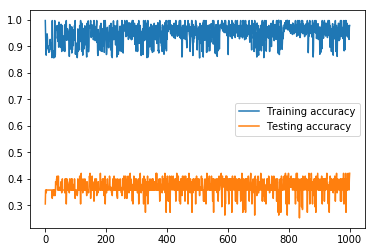

In [18]:
from matplotlib import pyplot as plt 
%matplotlib inline 
x_list =range(len(train_acc_list))

plt.plot(x_list, train_acc_list, label='Training accuracy')
plt.plot(x_list, test_acc_list, label='Testing accuracy')
plt.legend()
plt.show()

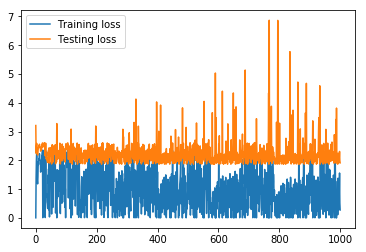

In [19]:
plt.plot(x_list, train_loss_list, label='Training loss')
plt.plot(x_list, test_loss_list, label='Testing loss')
plt.legend()
plt.show()